In [2]:
!pip install holidays
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import itertools
import re
import plotly.graph_objects as go
import gdown
import zipfile
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
from tqdm import tqdm
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import numpy as np


#  loading date

In [3]:
# Google Drive URL
zip_url = "https://drive.google.com/uc?id=1Jk5ANQ6noxdeJv73zhfxUym3lyuoVMq6"

# Function to download and read the zip archive containing CSV files
def download_and_read_csv_zip(zip_url):
    # Download the zip file from Google Drive
    output = 'archive.zip'
    gdown.download(zip_url, output, quiet=False)

    # Dictionary to store DataFrames
    dfs = {}

    # Open the zip file
    with zipfile.ZipFile(output, "r") as zip_ref:
        # Extract each CSV file from the zip archive
        for file_name in zip_ref.namelist():
            if file_name.endswith('.csv'):
                # Read the CSV file directly into a pandas DataFrame
                df = pd.read_csv(zip_ref.open(file_name), encoding='iso-8859-1')
                # Store the DataFrame in the dictionary
                dfs[file_name] = df

    return dfs

# Call the function with the zip URL
dfs = download_and_read_csv_zip(zip_url)

# View all DataFrames
for file_name, df in dfs.items():
    print("File:", file_name)
    print(df)
    print("="*50)


Downloading...
From (original): https://drive.google.com/uc?id=1Jk5ANQ6noxdeJv73zhfxUym3lyuoVMq6
From (redirected): https://drive.google.com/uc?id=1Jk5ANQ6noxdeJv73zhfxUym3lyuoVMq6&confirm=t&uuid=7dc2ed20-4153-4590-8e3b-da169b11953f
To: /content/archive.zip
100%|██████████| 45.0M/45.0M [00:01<00:00, 26.7MB/s]


File: S_Data/__MACOSX/._customers.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._geolocation.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._order_items.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._order_payments.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._order_reviews.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._orders.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/__MACOSX/._product_category_name_translation.csv
  Unnamed: 0
0        o\t
File: S_Data/__MACOSX/._products.csv
   Unnamed: 0
0          21
File: S_Data/__MACOSX/._sellers.csv
Empty DataFrame
Columns: [Unnamed: 0]
Index: []
File: S_Data/customers.csv
                            customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac

# Task 1. Forecasting
The main goal of this block is to implement a demand forecasting system for a short-term period (14 days) 7 days from the last date in the data for all product groups. We rely on the transaction data provided to you. It is important to make sure the system can produce a forecast for new products (which have little or no training data). We would like to see 2 approaches for comparison: using machine learning and classical time series forecasting.
The technical solution must be justified by comments regarding the appropriateness of a particular method or approach.


In [4]:
file_name ='S_Data/orders.csv'

if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    orders = dfs[file_name]

else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
orders


order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  
0               2017-10-18 00:00:00  
1               2018-08-13 00:00:00  
2               2018-09-04 00:00:00  
3               2017-12-15 00:00:00  
4               2018-02-26 00:00:00  
...                             ...  
99436           2017-03-28 00:00:00  
99437           2018-03-02 00:00:00  
99438           2017-09-27 00:00:00  
99439           2018-02-15 00:00:00  
99440           2018-04-03 00:00:00  

[99441 rows x 8 columns]

In [5]:
orders.duplicated().sum()

0

In [6]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [7]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [9]:
# Specify the file name you want to retrieve
file_name ='S_Data/products.csv'

# Check if the file exists in the dictionary
if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    products = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [10]:
orders.duplicated().sum()

0

In [11]:
file_name ='S_Data/product_category_name_translation.csv'
# Check if the file exists in the dictionary
if file_name in dfs:
    # Access the DataFrame corresponding to the file name
   product_category_name_translation = dfs[file_name]

else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
product_category_name_translation.columns

Index(['ï»¿product_category_name', 'product_category_name_english'], dtype='object')

In [12]:
product_category_name_translation.rename(columns={'ï»¿product_category_name':'product_category_name'}, inplace=True)


In [13]:
orders.duplicated().sum()

0

In [14]:
products = products.merge(product_category_name_translation, on ='product_category_name', how = 'left' )
#products = product_details.merge(product_translate, on='product_category_name', how='left')
products.isna().sum()

product_id                         0
product_category_name            610
product_name_lenght              610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english    623
dtype: int64

In [15]:
 #filling the missing values in product_category_name_english where there are values in product_category_name
products['product_category_name_english'] = np.where(products["product_category_name"] == 'portateis_cozinha_e_preparadores_de_alimentos',
                                                     'kitchen_portable_and_food_preparers', products['product_category_name_english'])

products['product_category_name_english'] = np.where(products["product_category_name"] == 'pc_gamer',
                                                     'pc_gaming', products['product_category_name_english'])

In [16]:
# filling the remain missing values in product_category_name and product_category_name_english with no_product_name
products['product_category_name'].fillna('not_defined_product', inplace= True)
products['product_category_name_english'].fillna('not_defined_product', inplace= True)

# filling with 0 for another missing numeric values
products.fillna(0, inplace=True)

# checking missing values again
products.isna().sum()

product_id                       0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
dtype: int64

In [17]:
# Rename column
products.rename(columns={'product_category_name_english': 'product_name'}, inplace=True)

In [18]:
file_name = 'S_Data/order_items.csv'

if file_name in dfs:
    # Access the DataFrame corresponding to the file name
    order_items = dfs[file_name]
else:
    print("File '{}' does not exist in the dictionary of DataFrames".format(file_name))
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [19]:
# Checking for any duplicated data in the column order_id
print('order_id duplicated : ',order_items['order_id'].duplicated().sum())
print('product_id duplicated : ',order_items['product_id'].duplicated().sum())
print('seller_id duplicated : ',order_items['seller_id'].duplicated().sum())

order_id duplicated :  13984
product_id duplicated :  79699
seller_id duplicated :  109555


In [20]:
order_items.groupby('order_id').agg(
    order_item_count=('order_item_id', 'count'),
    unique_product=('product_id', 'nunique'),
    unique_seller=('seller_id', 'nunique')
).sort_values('unique_product', ascending=False)\
.reset_index().head()

order_id  order_item_count  unique_product  \
0  ca3625898fbd48669d50701aba51cd5f                10               8   
1  7d8f5bfd5aff648220374a2df62e84d5                 7               7   
2  77df84f9195be22a4e9cb72ca9e8b4c2                 7               7   
3  ad850e69fce9a512ada84086651a2e7d                 7               7   
4  5efc0b7fe9df7f0c567404abaa4d25fc                 6               6   

   unique_seller  
0              2  
1              1  
2              3  
3              1  
4              1

There are duplicated records, caused by instances where the same order_id has multiple order_item_id entries with different products and sellers, indicating purchases of more than one item


In [21]:
merged_df = pd.merge(products, order_items, on='product_id', how='outer')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   product_id                  112650 non-null  object 
 1   product_category_name       112650 non-null  object 
 2   product_name_lenght         112650 non-null  float64
 3   product_description_lenght  112650 non-null  float64
 4   product_photos_qty          112650 non-null  float64
 5   product_weight_g            112650 non-null  float64
 6   product_length_cm           112650 non-null  float64
 7   product_height_cm           112650 non-null  float64
 8   product_width_cm            112650 non-null  float64
 9   product_name                112650 non-null  object 
 10  order_id                    112650 non-null  object 
 11  order_item_id               112650 non-null  int64  
 12  seller_id                   112650 non-null  object 
 13  shipping_limit

In [22]:
df = pd.merge(merged_df, orders, on='order_id', how='outer')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   product_id                     112650 non-null  object        
 1   product_category_name          112650 non-null  object        
 2   product_name_lenght            112650 non-null  float64       
 3   product_description_lenght     112650 non-null  float64       
 4   product_photos_qty             112650 non-null  float64       
 5   product_weight_g               112650 non-null  float64       
 6   product_length_cm              112650 non-null  float64       
 7   product_height_cm              112650 non-null  float64       
 8   product_width_cm               112650 non-null  float64       
 9   product_name                   112650 non-null  object        
 10  order_id                       113425 non-null  object        
 11  

In [23]:
df['product_name'].fillna('not_defined_product', inplace= True)
df['product_name'] = df['product_name'].astype('category')
product_category = dict(zip(df['product_name'].cat.codes, df['product_name']))

df['product_name']

0                   perfumery
1                         art
2              sports_leisure
3                        baby
4                  housewares
                 ...         
113420    not_defined_product
113421    not_defined_product
113422    not_defined_product
113423    not_defined_product
113424    not_defined_product
Name: product_name, Length: 113425, dtype: category
Categories (74, object): ['agro_industry_and_commerce', 'air_conditioning', 'art', 'arts_and_craftmanship', ...,
                          'tablets_printing_image', 'telephony', 'toys', 'watches_gifts']

Let's check items that are most sold

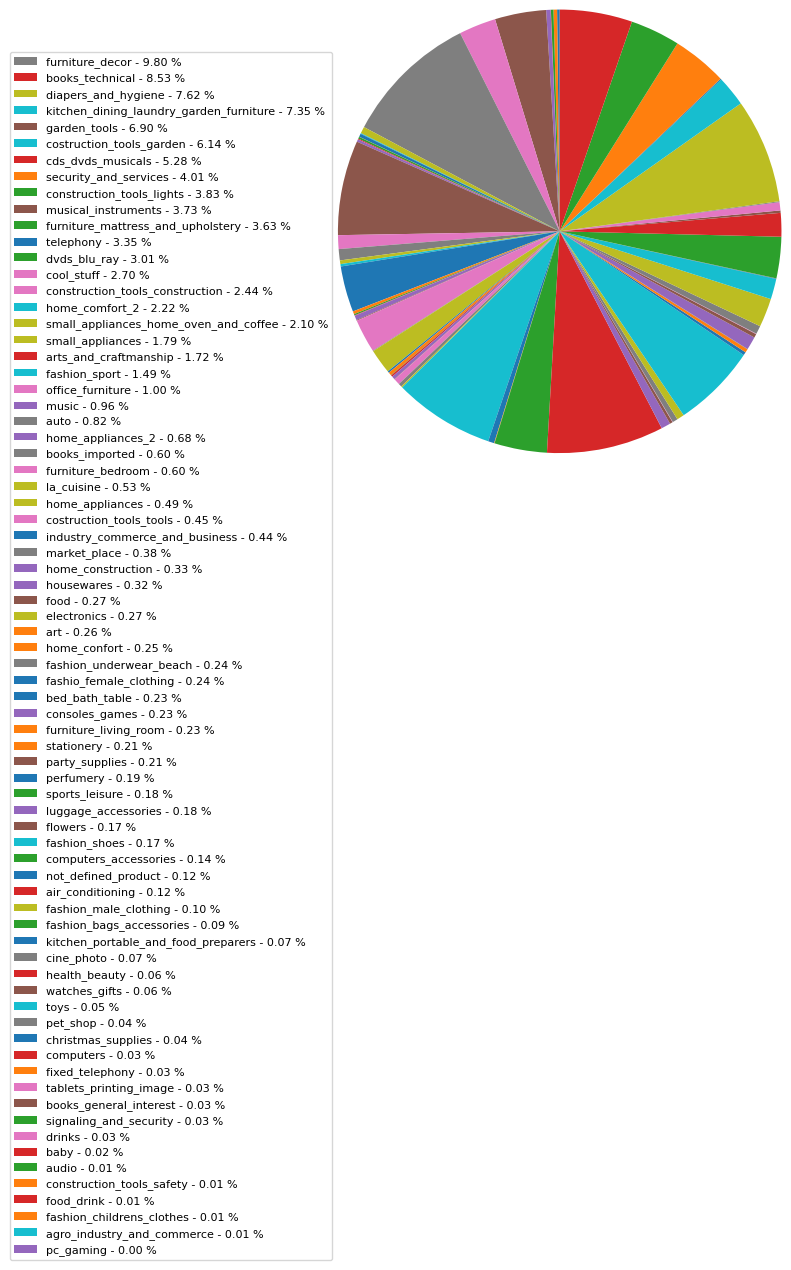

In [24]:
data_grouped_product = df.groupby(['product_name']).count()[['order_id']]

data_grouped_product['%_s'] = 100 * data_grouped_product['order_id'] / data_grouped_product['order_id'].sum()
data_grouped_product['%_s'] = data_grouped_product['%_s'].round(decimals = 3)


percent = 100 * data_grouped_product['order_id'] / data_grouped_product['order_id'].sum()
percent = percent.round(decimals = 3)
patches, texts = plt.pie(data_grouped_product['%_s'], startangle=90, radius=1.5)


lables_2 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(product_category.values(), percent)]


sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, lables_2, data_grouped_product['%_s']),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)


Text(0.5, 1.0, 'Sales per month for each store')

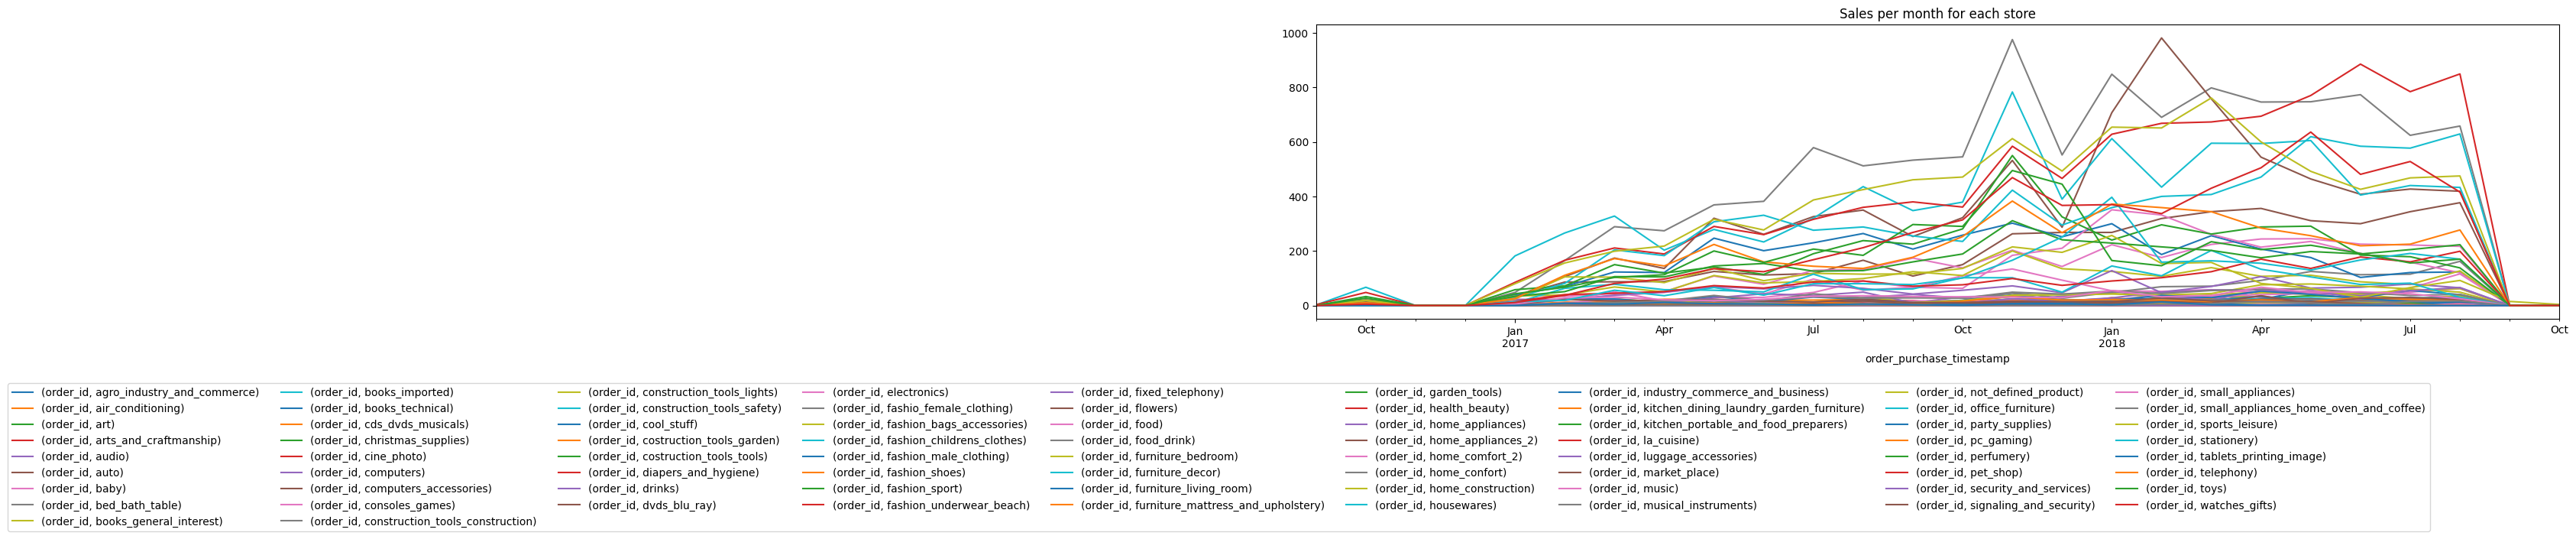

In [25]:
sales = (
    df
    .groupby(['order_purchase_timestamp', 'product_name'])
    .aggregate({'order_id': 'count'})
    .unstack()
    .resample('1M')
    .sum()
)
sales.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(0.9,-.2), ncol=9)
plt.title("Sales per month for each store")

as we work with the demand for products we choose the time of ordering as follows  order purchase timestamp

In [26]:
 #Select relevant columns
orders = df[['order_id', 'product_id', 'order_purchase_timestamp', 'product_name']]

# Filter rows based on the date range
orders = orders[(df['order_purchase_timestamp'] >= pd.to_datetime('2017-01-01')) &
                (df['order_purchase_timestamp'] <= pd.to_datetime('2018-08-20'))].copy()

# Add new columns for different datetime attributes
orders.loc[:, 'hour'] = orders['order_purchase_timestamp'].dt.hour
orders.loc[:, 'dayofweek'] = orders['order_purchase_timestamp'].dt.dayofweek
orders.loc[:, 'quarter'] = orders['order_purchase_timestamp'].dt.quarter
orders.loc[:, 'month'] = orders['order_purchase_timestamp'].dt.month
orders.loc[:, 'year'] = orders['order_purchase_timestamp'].dt.year
orders.loc[:, 'dayofyear'] = orders['order_purchase_timestamp'].dt.dayofyear
orders.loc[:, 'dayofmonth'] = orders['order_purchase_timestamp'].dt.day
orders.loc[:, 'date'] = orders['order_purchase_timestamp'].dt.date
orders.loc[:, 'weekofyear'] = orders['order_purchase_timestamp'].dt.isocalendar().week
orders

order_id                        product_id  \
0       e17e4f88e31525f7deef66779844ddce  1e9e8ef04dbcff4541ed26657ea517e5   
1       5236307716393b7114b53ee991f36956  3aa071139cb16b67ca9e5dea641aaa2f   
2       01f66e58769f84129811d43eefd187fb  96bd76ec8810374ed1b65e291975717f   
3       143d00a4f2dde4e0364ee1821577adb3  cef67bcfe19066a932b7673e239eb23d   
4       86cafb8794cb99a9b1b77fc8e48fbbbb  9dc1a7de274444849c219cff195d0b71   
...                                  ...                               ...   
113418  6cf5c427fb11bc5fe8abefa86aa7ba0b                               NaN   
113419  1c7c8ab324927f5b6e52338bd110bef4                               NaN   
113420  aaab15da689073f8f9aa978a390a69d1                               NaN   
113423  a69ba794cc7deb415c3e15a0a3877e69                               NaN   
113424  5fabc81b6322c8443648e1b21a6fef21                               NaN   

       order_purchase_timestamp         product_name  hour  dayofweek  \
0           2018-04-24 16:16:53            perfumery    16          1   
1           2018-01-31 18:55:36                  art    18          2   
2           2018-07-09 21:18:01       sports_leisure    21          0   
3           2018-08-03 08:55:50                 baby     8          4   
4           2018-04-11 01:06:37           housewares     1          2   
...                         ...                  ...   ...        ...   
113418      2017-10-17 10:53:48  not_defined_product    10          1   
113419      2017-12-23 18:48:09  not_defined_product    18          5   
113420      2018-01-16 14:27:59  not_defined_product    14          1   
113423      2017-08-23 16:28:04  not_defined_product    16          2   
113424      2017-10-10 10:50:03  not_defined_product    10          1   

        quarter  month  year  dayofyear  dayofmonth        date  weekofyear  
0             2      4  2018        114          24  2018-04-24          17  
1             1      1  2018         31          31  2018-01-31           5  
2             3      7  2018        190           9  2018-07-09          28  
3             3      8  2018        215           3  2018-08-03          31  
4             2      4  2018        101          11  2018-04-11          15  
...         ...    ...   ...        ...         ...         ...         ...  
113418        4     10  2017        290          17  2017-10-17          42  
113419        4     12  2017        357          23  2017-12-23          51  
113420        1      1  2018         16          16  2018-01-16           3  
113423        3      8  2017        235          23  2017-08-23          34  
113424        4     10  2017        283          10  2017-10-10          41  

[111668 rows x 13 columns]

<Axes: xlabel='date'>

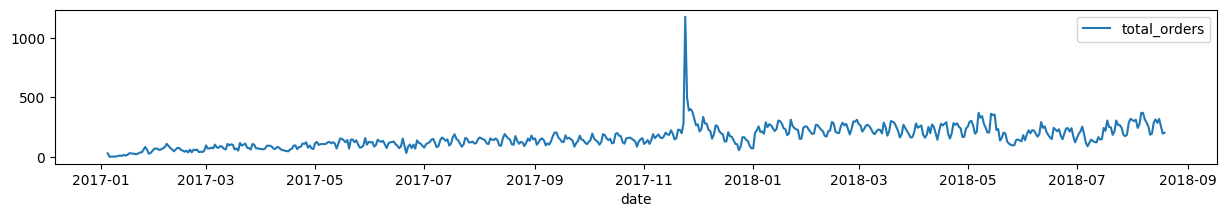

In [27]:
daily_order = orders.groupby('date').agg(total_orders=('order_id', 'nunique'))
plt.figure(figsize=(15,2))
sns.lineplot(data=daily_order)

<Axes: xlabel='date'>

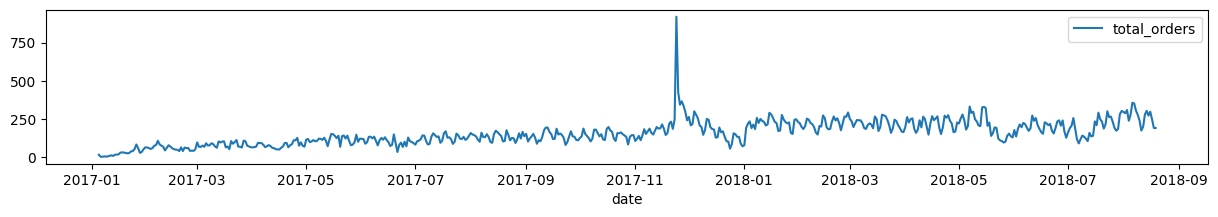

In [28]:
daily_order = orders.groupby('date').agg(total_orders=('product_id', 'nunique'))
plt.figure(figsize=(15,2))
sns.lineplot(data=daily_order)

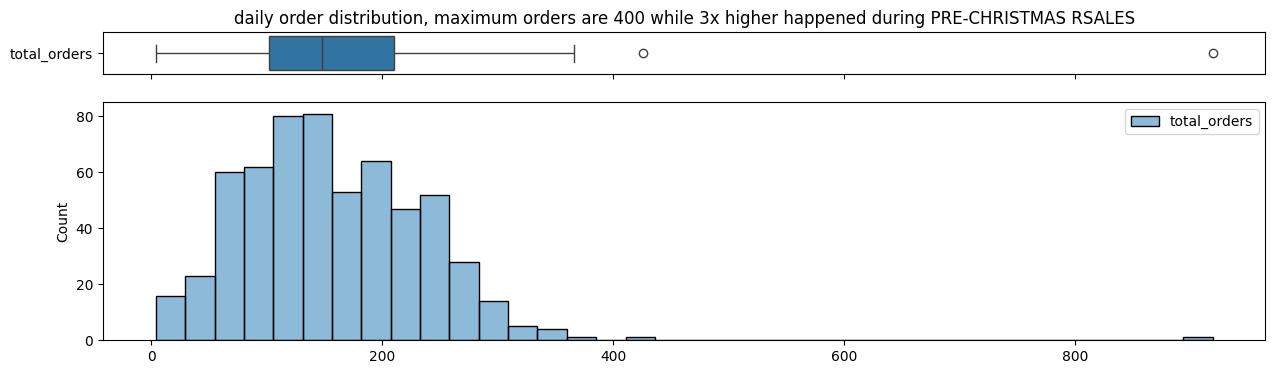

In [29]:
# Let's take a look at the daily order distribution
# the maximum order in a day is around 400, while in PRE-CHRISTMAS RSALES it can get into 1.2k or 3 times higher.

fig, ax = plt.subplots(2,1,sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,4))
sns.boxplot(data=daily_order, orient="h", ax=ax[0])
sns.histplot(daily_order, ax=ax[1])
ax[0].set_title("daily order distribution, maximum orders are 400 while 3x higher happened during PRE-CHRISTMAS RSALES")
plt.show()

In [30]:
avg_sales = orders.groupby('date').agg({'product_id': 'count'}).reset_index()
avg_sales['Time'] = np.arange(len(avg_sales.index))
avg_sales.head()

date  product_id  Time
0  2017-01-05          32     0
1  2017-01-06           4     1
2  2017-01-07           5     2
3  2017-01-08           6     3
4  2017-01-09           6     4

In [31]:
avg_sales['product_id'].max()

1366

In [32]:
max_data = avg_sales[avg_sales['product_id'] == 1366]
max_data

date  product_id  Time
323  2017-11-24        1366   323

<ipython-input-33-249a9b4afb66>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


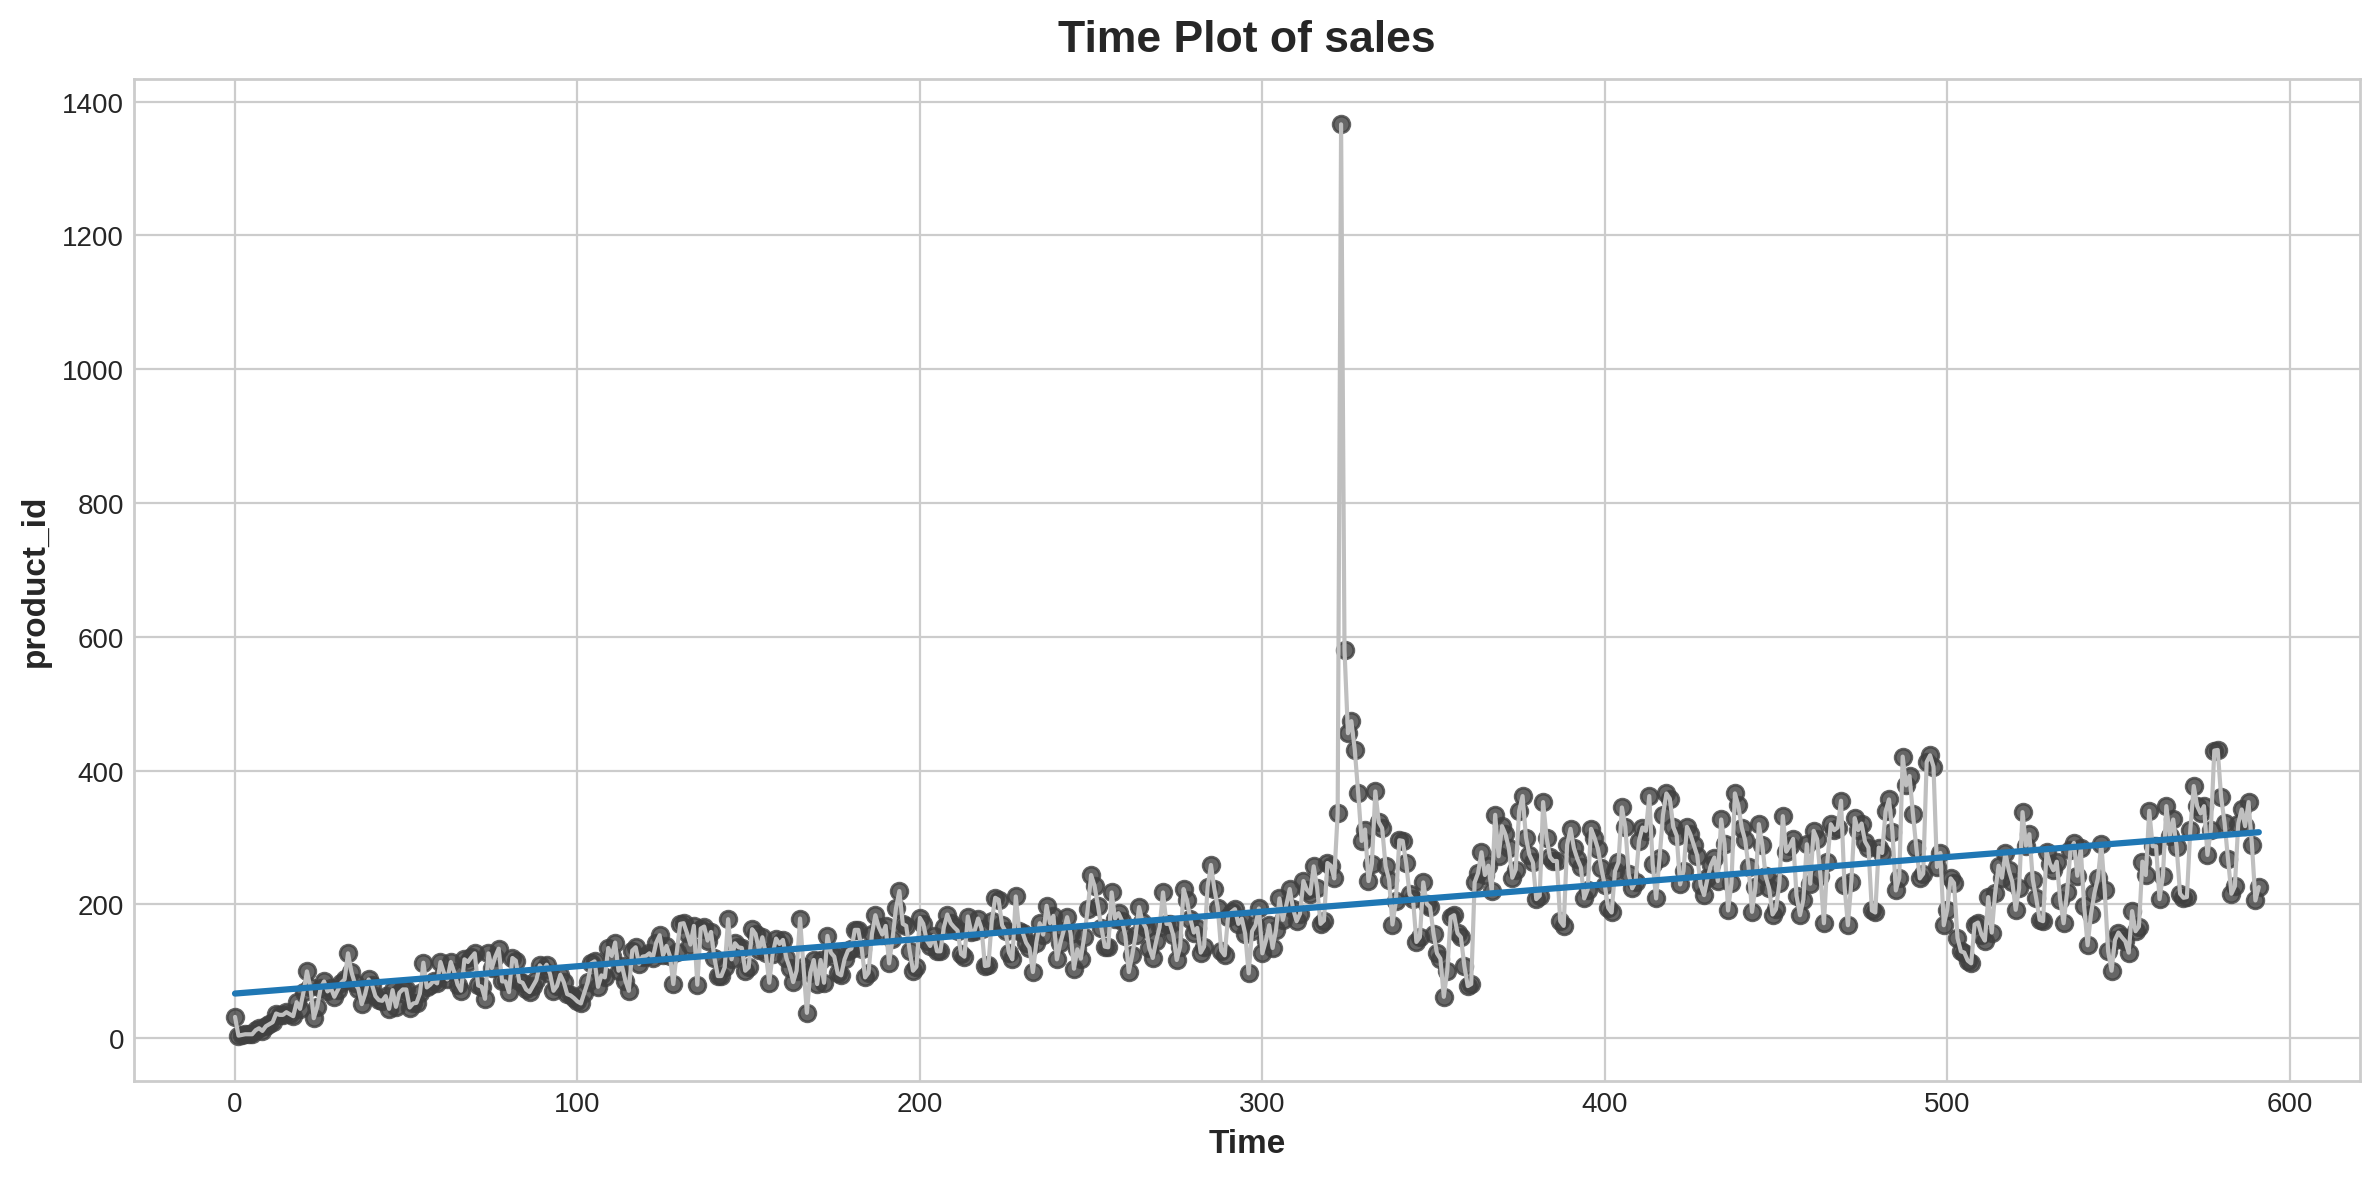

In [33]:
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

# Use it for the Lag_1 plot later.
plot_params = dict(
    color = '0.75',
    style = ".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina' # You can remove

fig, ax = plt.subplots()
ax.plot('Time', 'product_id', data=avg_sales, color='0.75')
ax = sns.regplot(x='Time', y='product_id', data=avg_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of sales');

In [34]:
avg_sales['Lag_1'] = avg_sales['product_id'].shift(1)
avg_sales = avg_sales.reindex(columns = ['date','product_id', 'Lag_1','Time'])
avg_sales.head()

date  product_id  Lag_1  Time
0  2017-01-05          32    NaN     0
1  2017-01-06           4   32.0     1
2  2017-01-07           5    4.0     2
3  2017-01-08           6    5.0     3
4  2017-01-09           6    6.0     4

Text(0.5, 1.0, 'Lag Plot of sales')

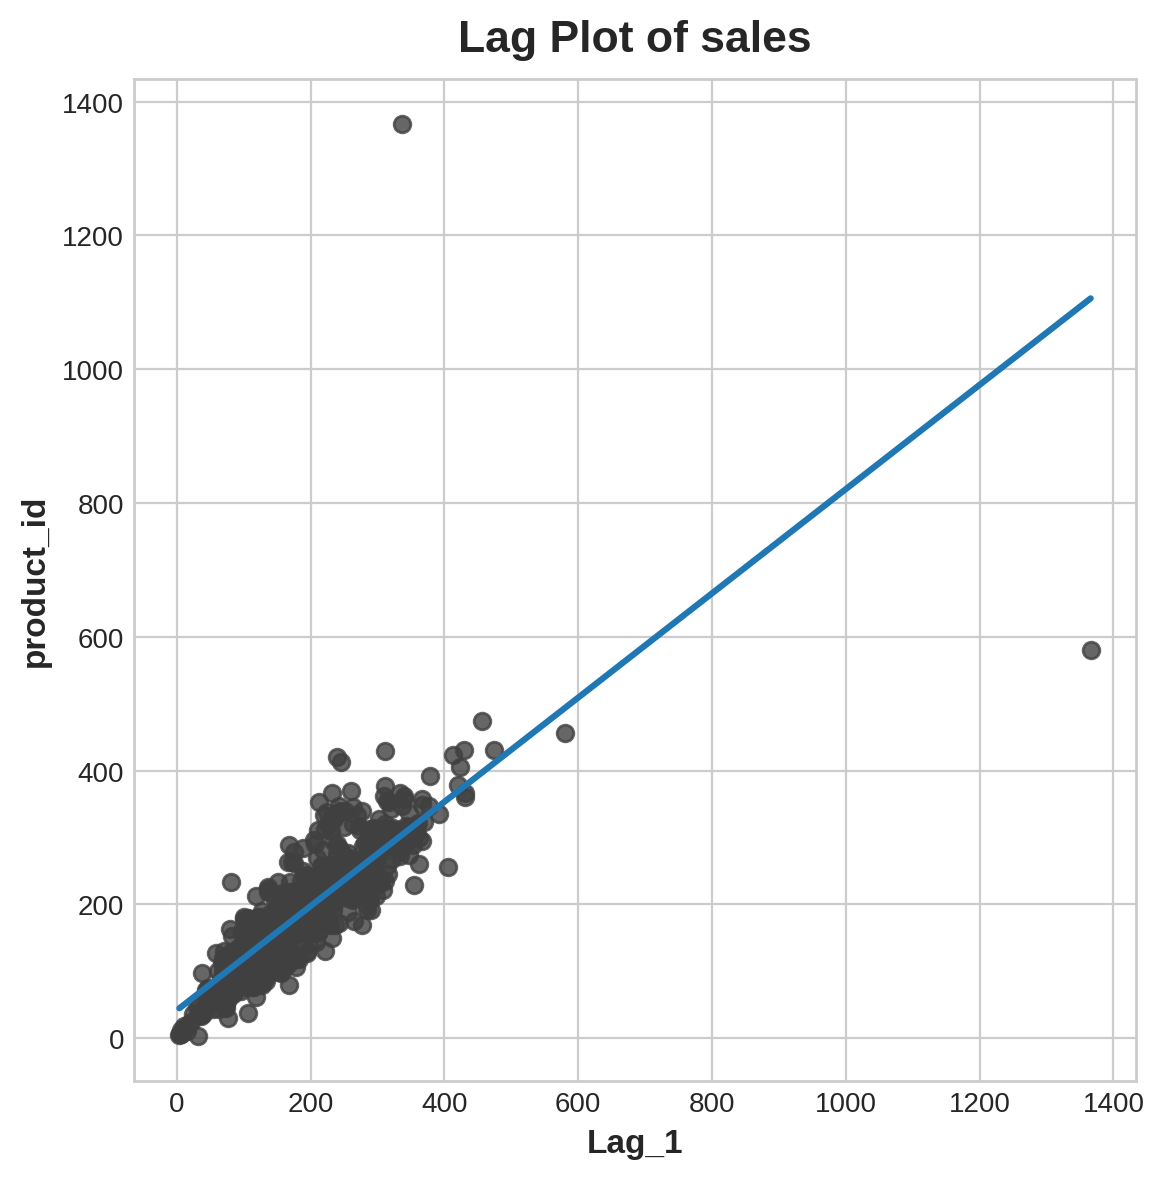

In [35]:
fig, ax = plt.subplots()
ax = sns.regplot(x = 'Lag_1', y = 'product_id', data = avg_sales, ci = None, scatter_kws = dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of sales')

In [36]:
from sklearn.linear_model import LinearRegression

# Training data
X = avg_sales.loc[:, ['Time']] # features
y = avg_sales.loc[:, 'product_id'] # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index = X.index)
y_pred

0       66.857282
1       67.265291
2       67.673300
3       68.081309
4       68.489319
          ...    
587    306.358654
588    306.766663
589    307.174673
590    307.582682
591    307.990691
Length: 592, dtype: float64

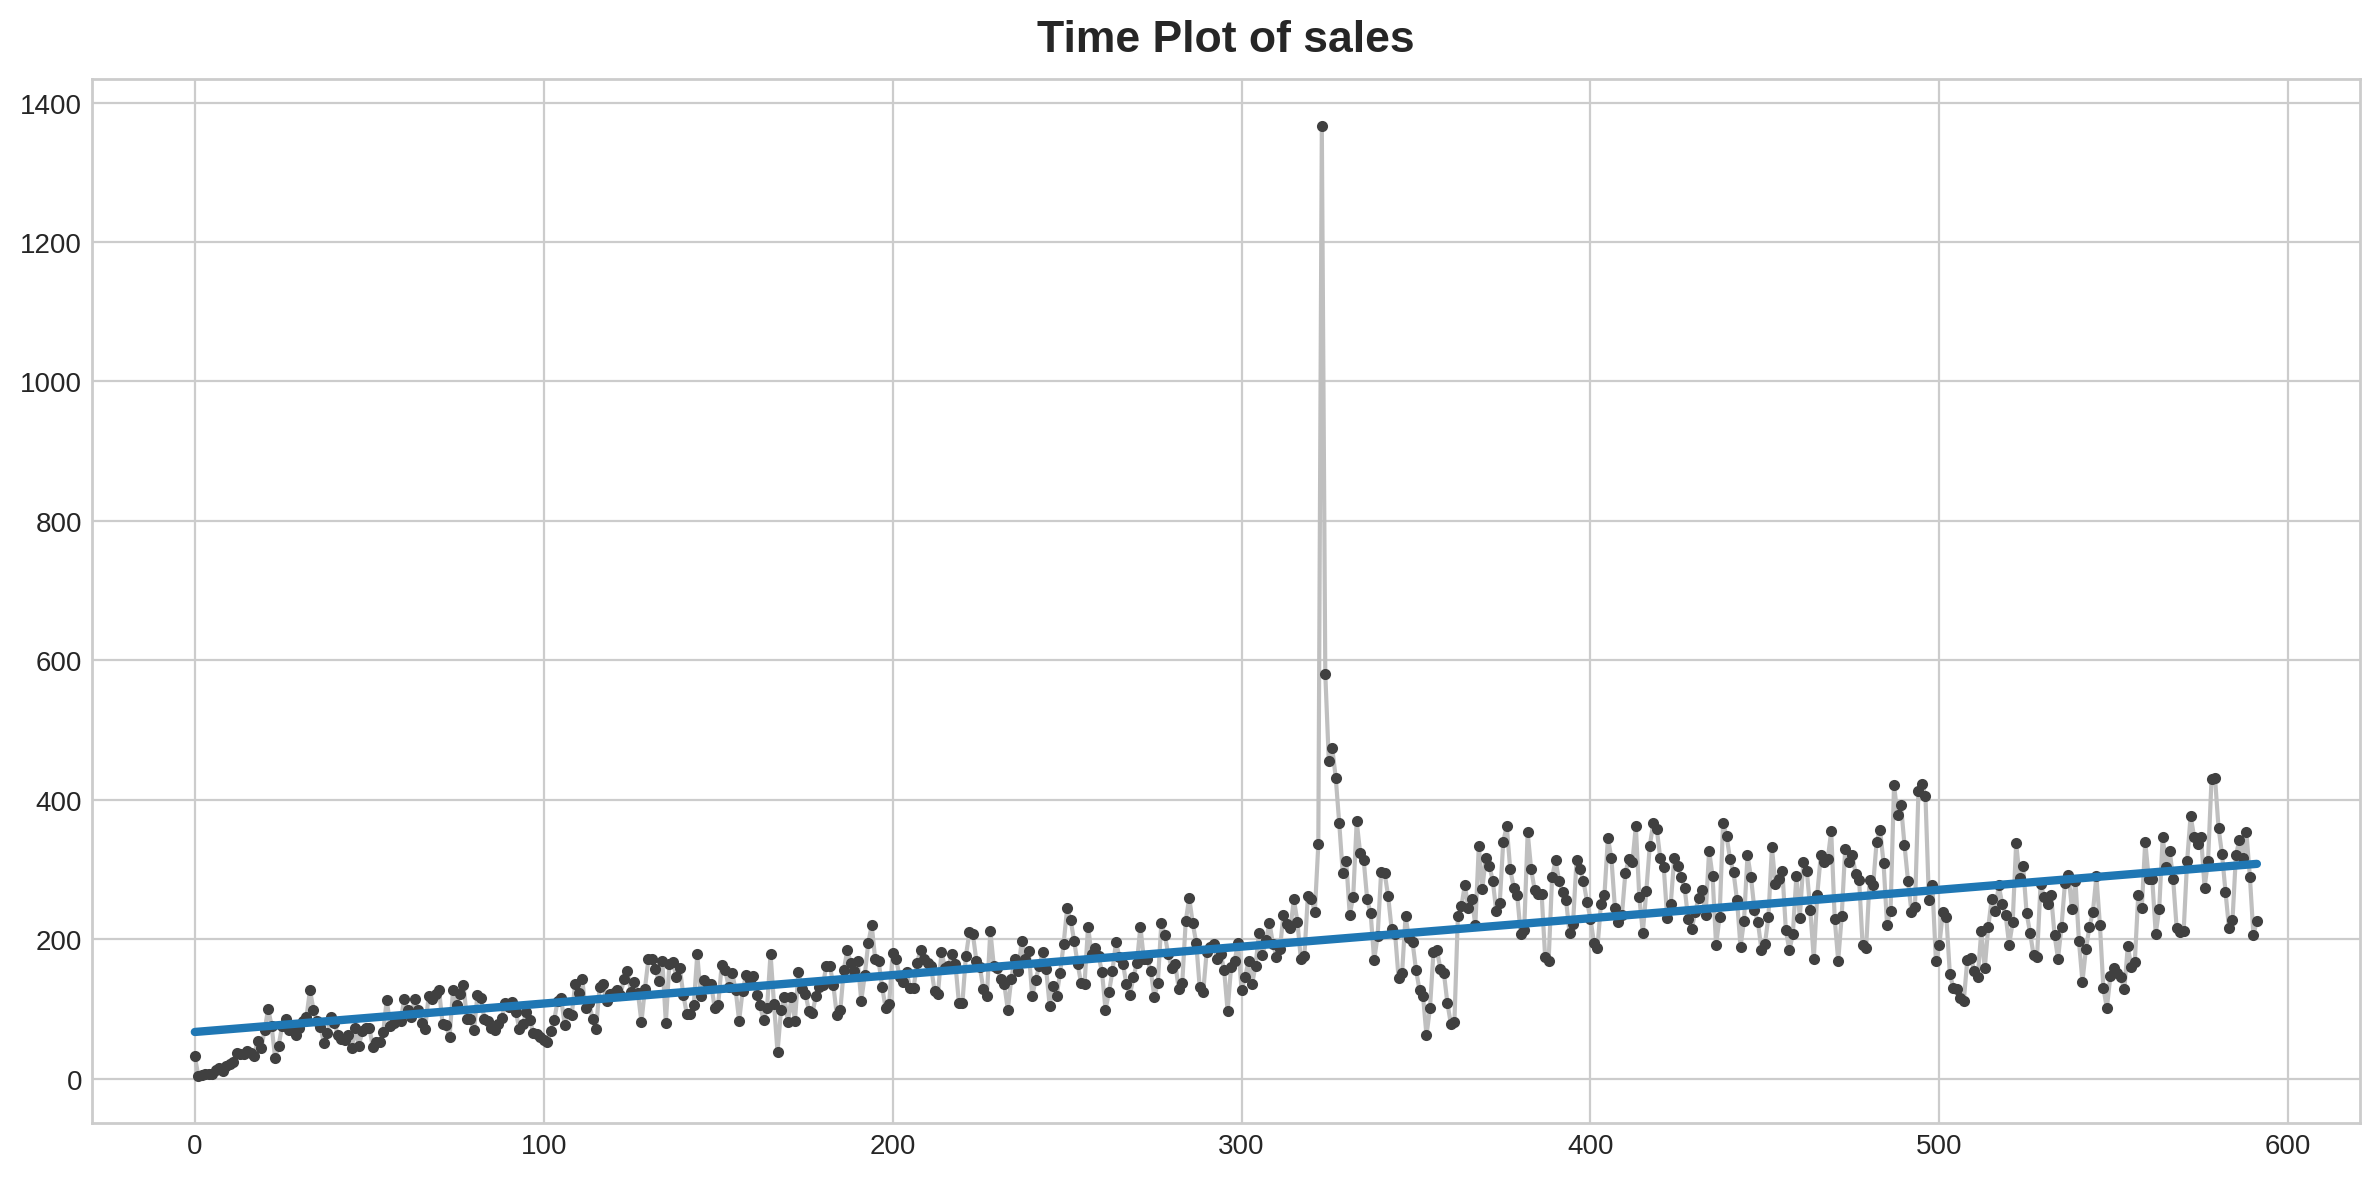

In [37]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth = 3)
ax.set_title('Time Plot of sales');

In [38]:
from sklearn.linear_model import LinearRegression

X = avg_sales.loc[:, ['Lag_1']]
X.dropna(inplace = True) # drop missing values in the feature set
y = avg_sales.loc[:, 'product_id'] # create the target
y, X = y.align(X, join = 'inner') # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

1       66.656475
2       44.843383
3       45.622422
4       46.401461
5       46.401461
          ...    
587    308.158563
588    288.682589
589    316.727992
590    266.869497
591    202.209260
Length: 591, dtype: float64

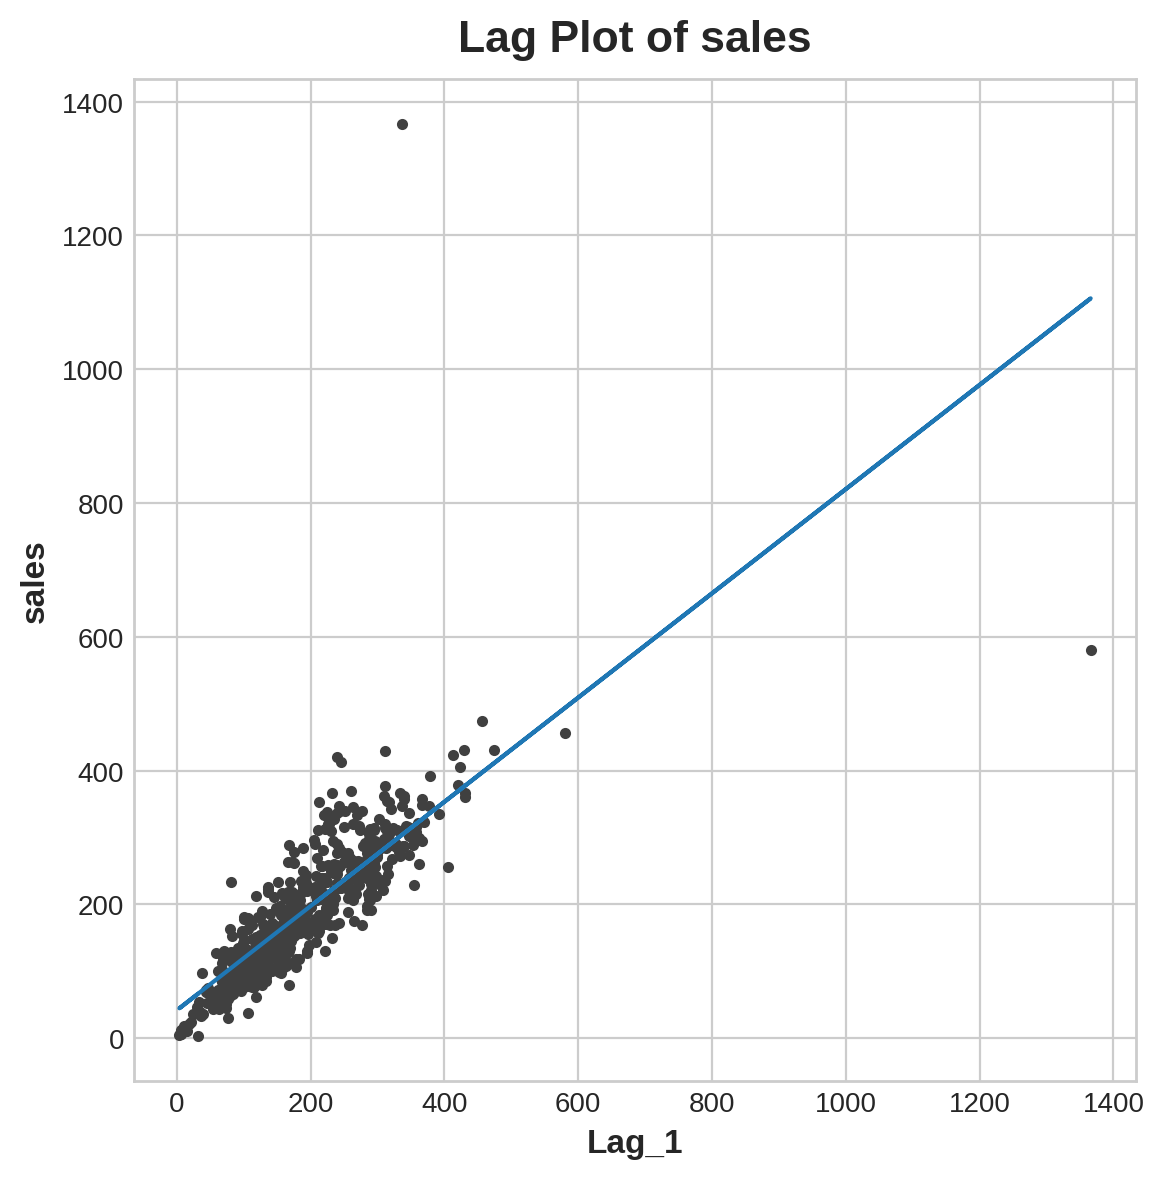

In [39]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('sales')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of sales');

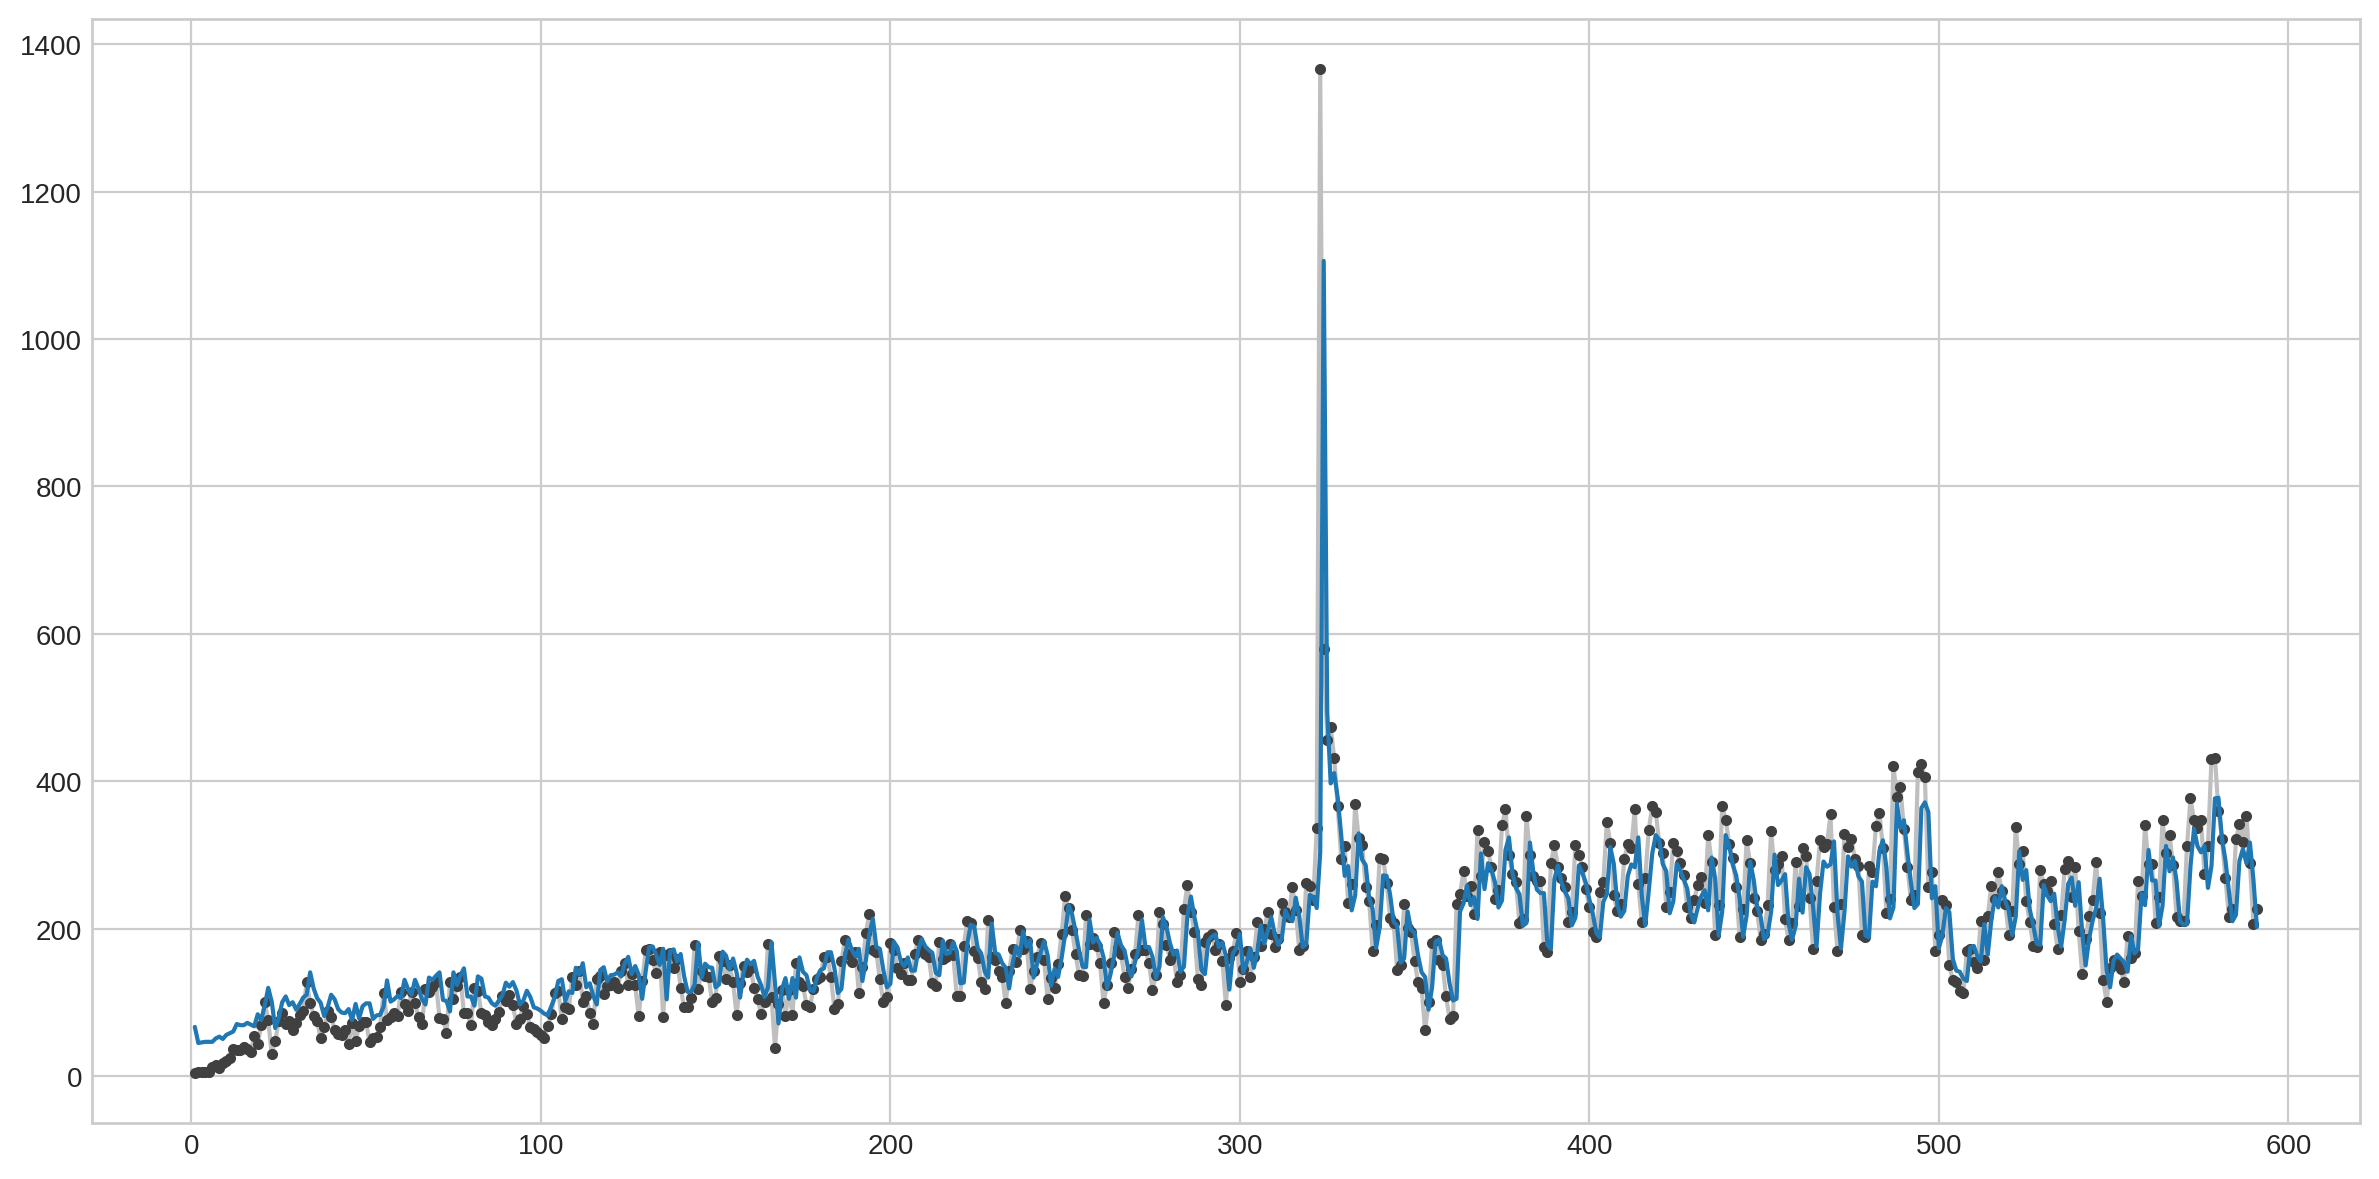

In [40]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

In [ ]:
#Indeed, linear regression alone can get rid of noise

Trend

In [41]:
from pathlib import Path
from warnings import simplefilter

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Load the sales dataset
avg_sales = orders.groupby('date').agg({'product_id': 'count'}).reset_index()
#avg_sales = avg_sales.set_index('date')
#avg_sales.index = pd.to_datetime(avg_sales.index)
avg_sales['date'] = pd.to_datetime(avg_sales['date'])

# Set the 'date' column as the index
avg_sales = avg_sales.set_index('date')

# Convert the DatetimeIndex to a PeriodIndex with daily frequency
avg_sales = avg_sales.to_period("D")

# Display the resulting DataFrame
avg_sales.head()



product_id
date                  
2017-01-05          32
2017-01-06           4
2017-01-07           5
2017-01-08           6
2017-01-09           6

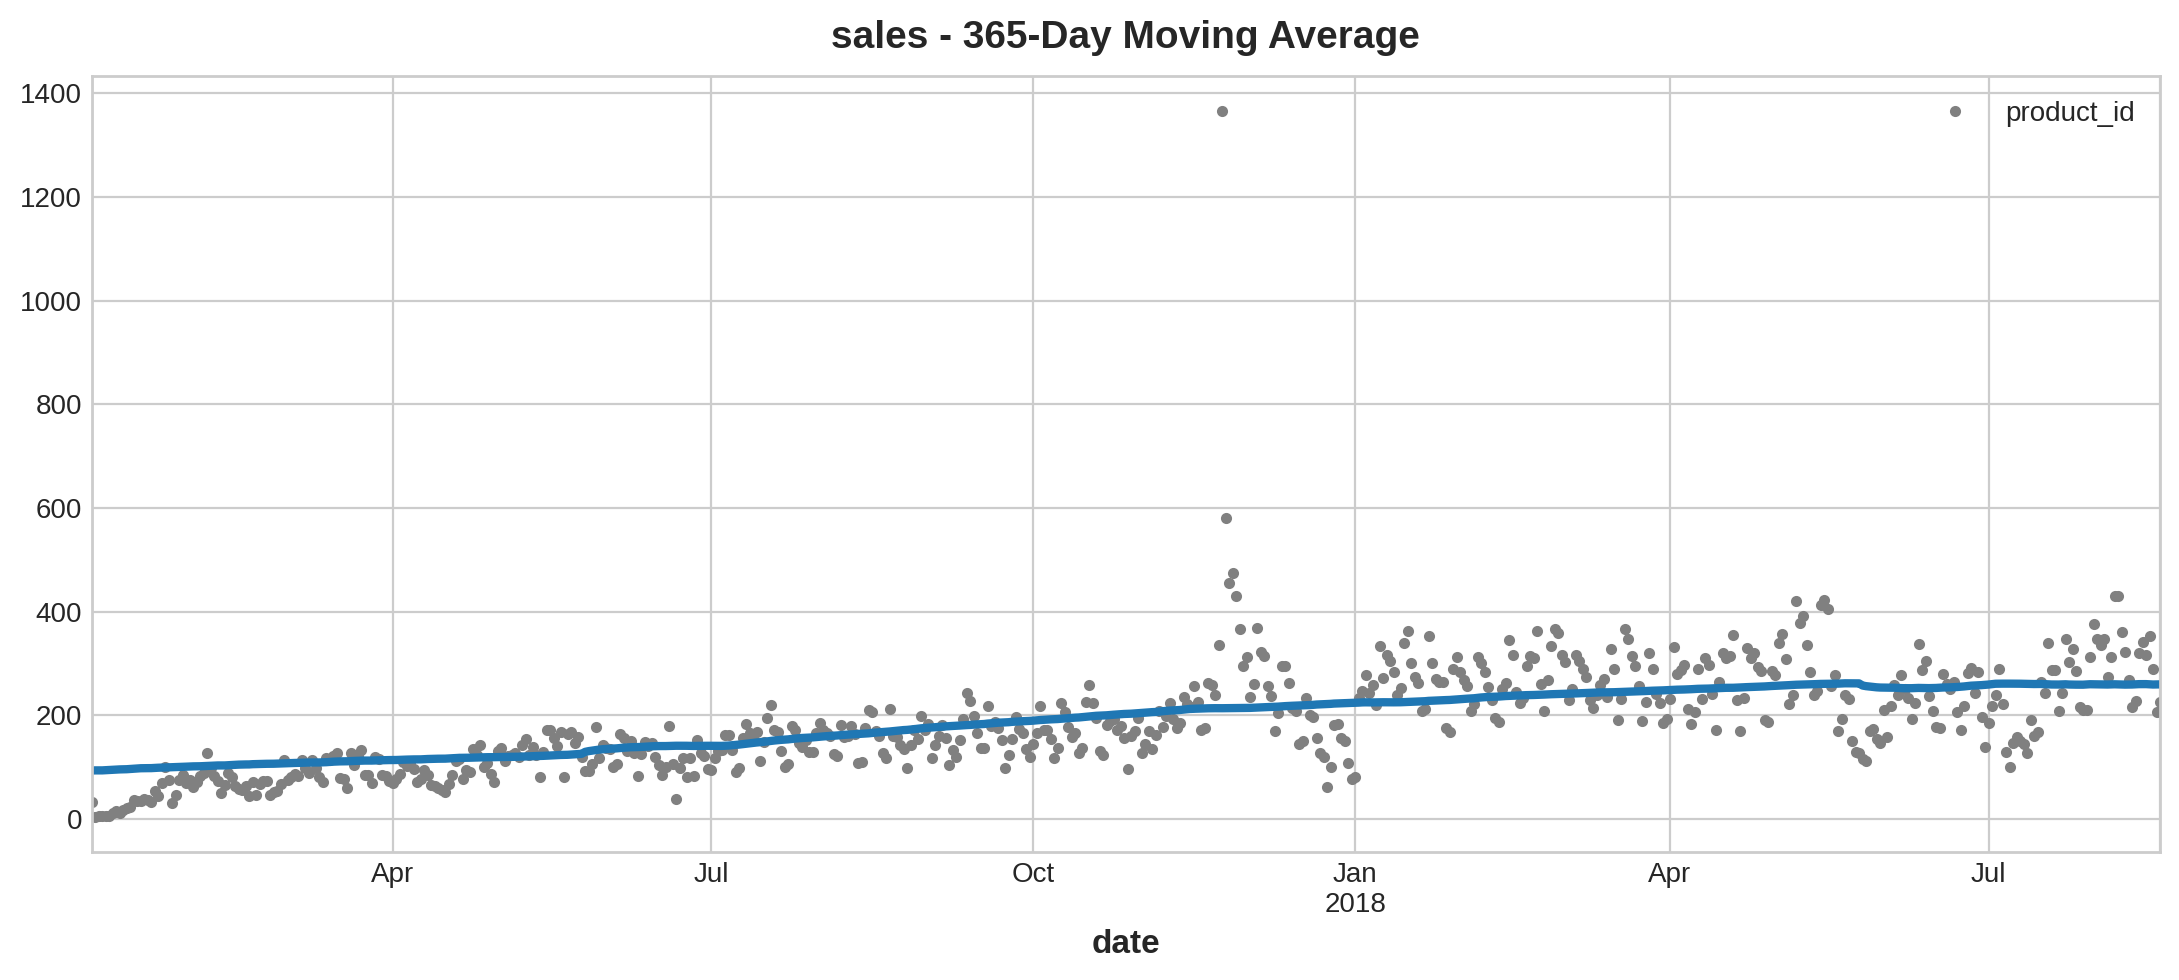

In [42]:
moving_average = avg_sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = avg_sales.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="sales - 365-Day Moving Average", legend=False,
);

In [43]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=avg_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

const  trend
date                    
2017-01-05    1.0    1.0
2017-01-06    1.0    2.0
2017-01-07    1.0    3.0
2017-01-08    1.0    4.0
2017-01-09    1.0    5.0

In [44]:
from sklearn.linear_model import LinearRegression
y = avg_sales["product_id"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

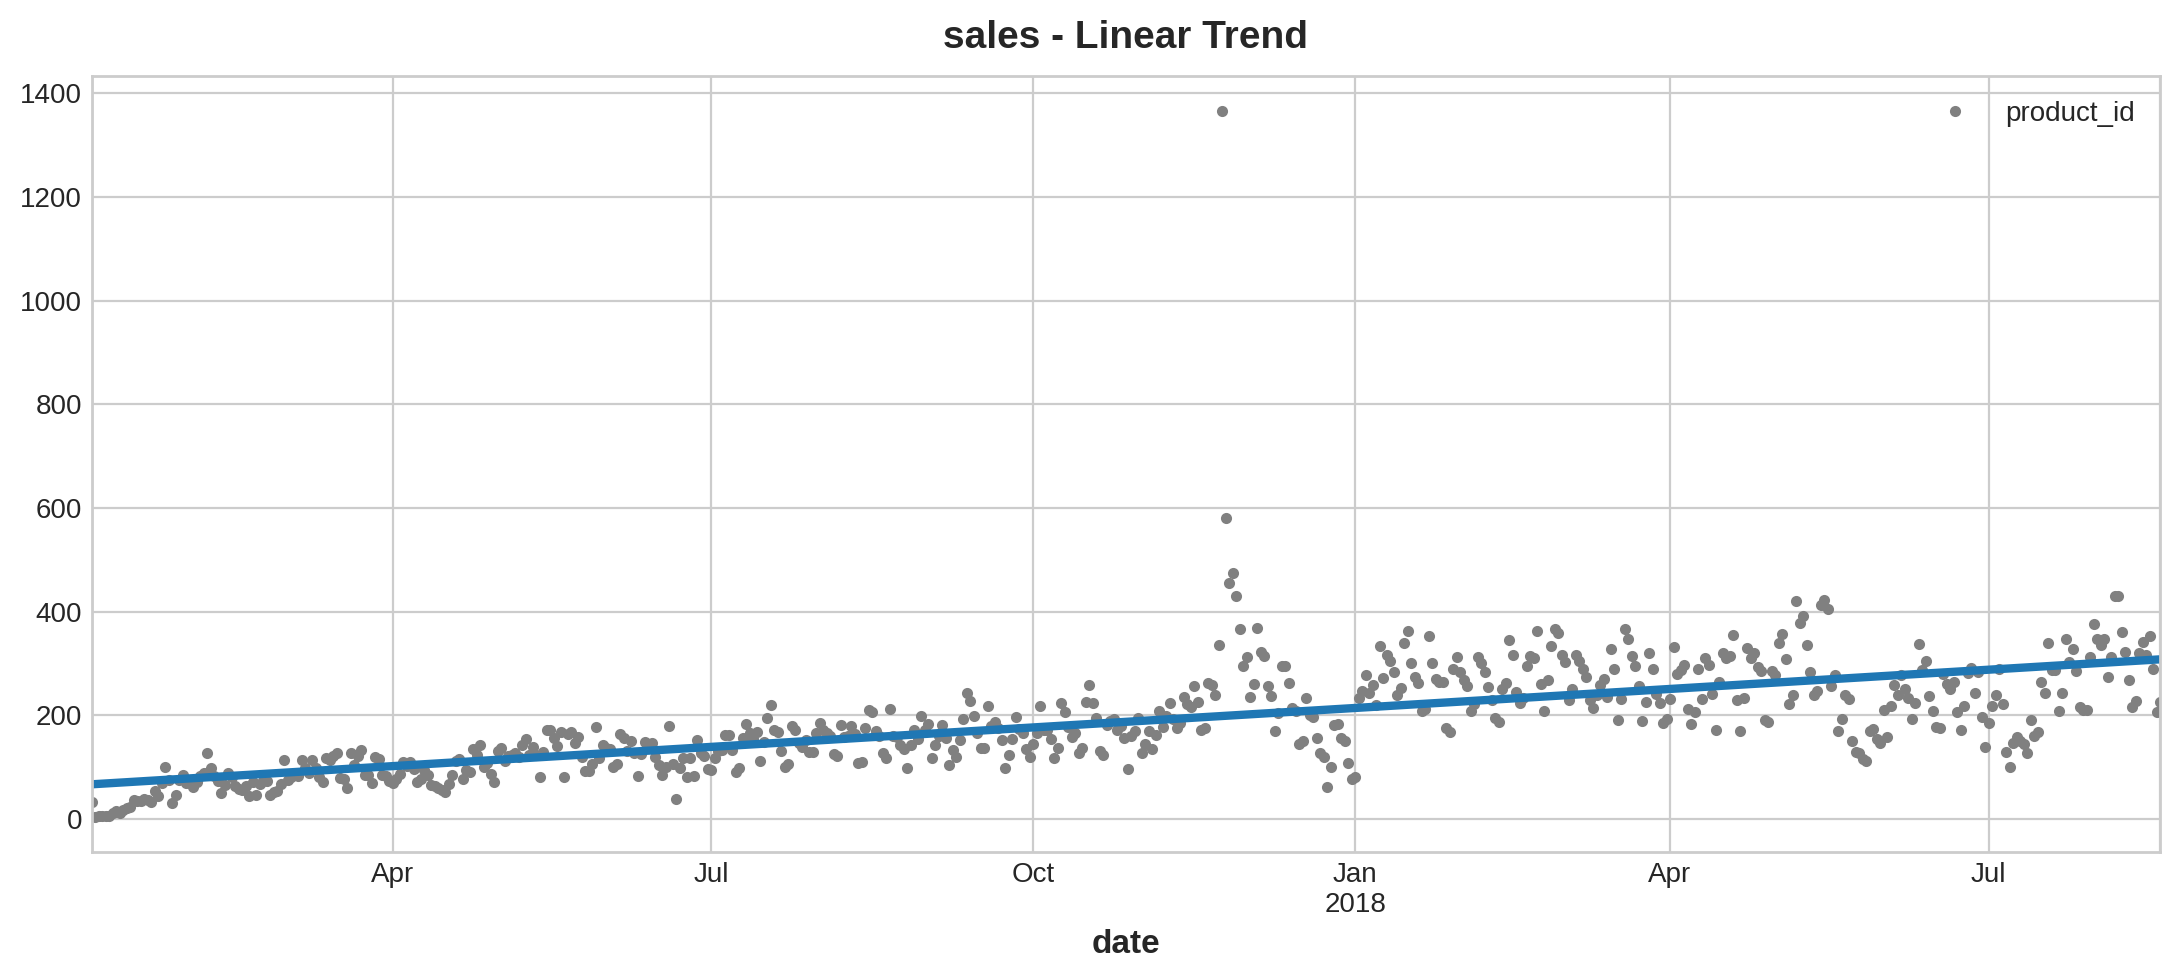

In [45]:
ax = avg_sales.plot(style=".", color="0.5", title="sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")


In [46]:
X = dp.out_of_sample(steps=180)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2018-08-20    308.398700
2018-08-21    308.806709
2018-08-22    309.214718
2018-08-23    309.622728
2018-08-24    310.030737
Freq: D, dtype: float64

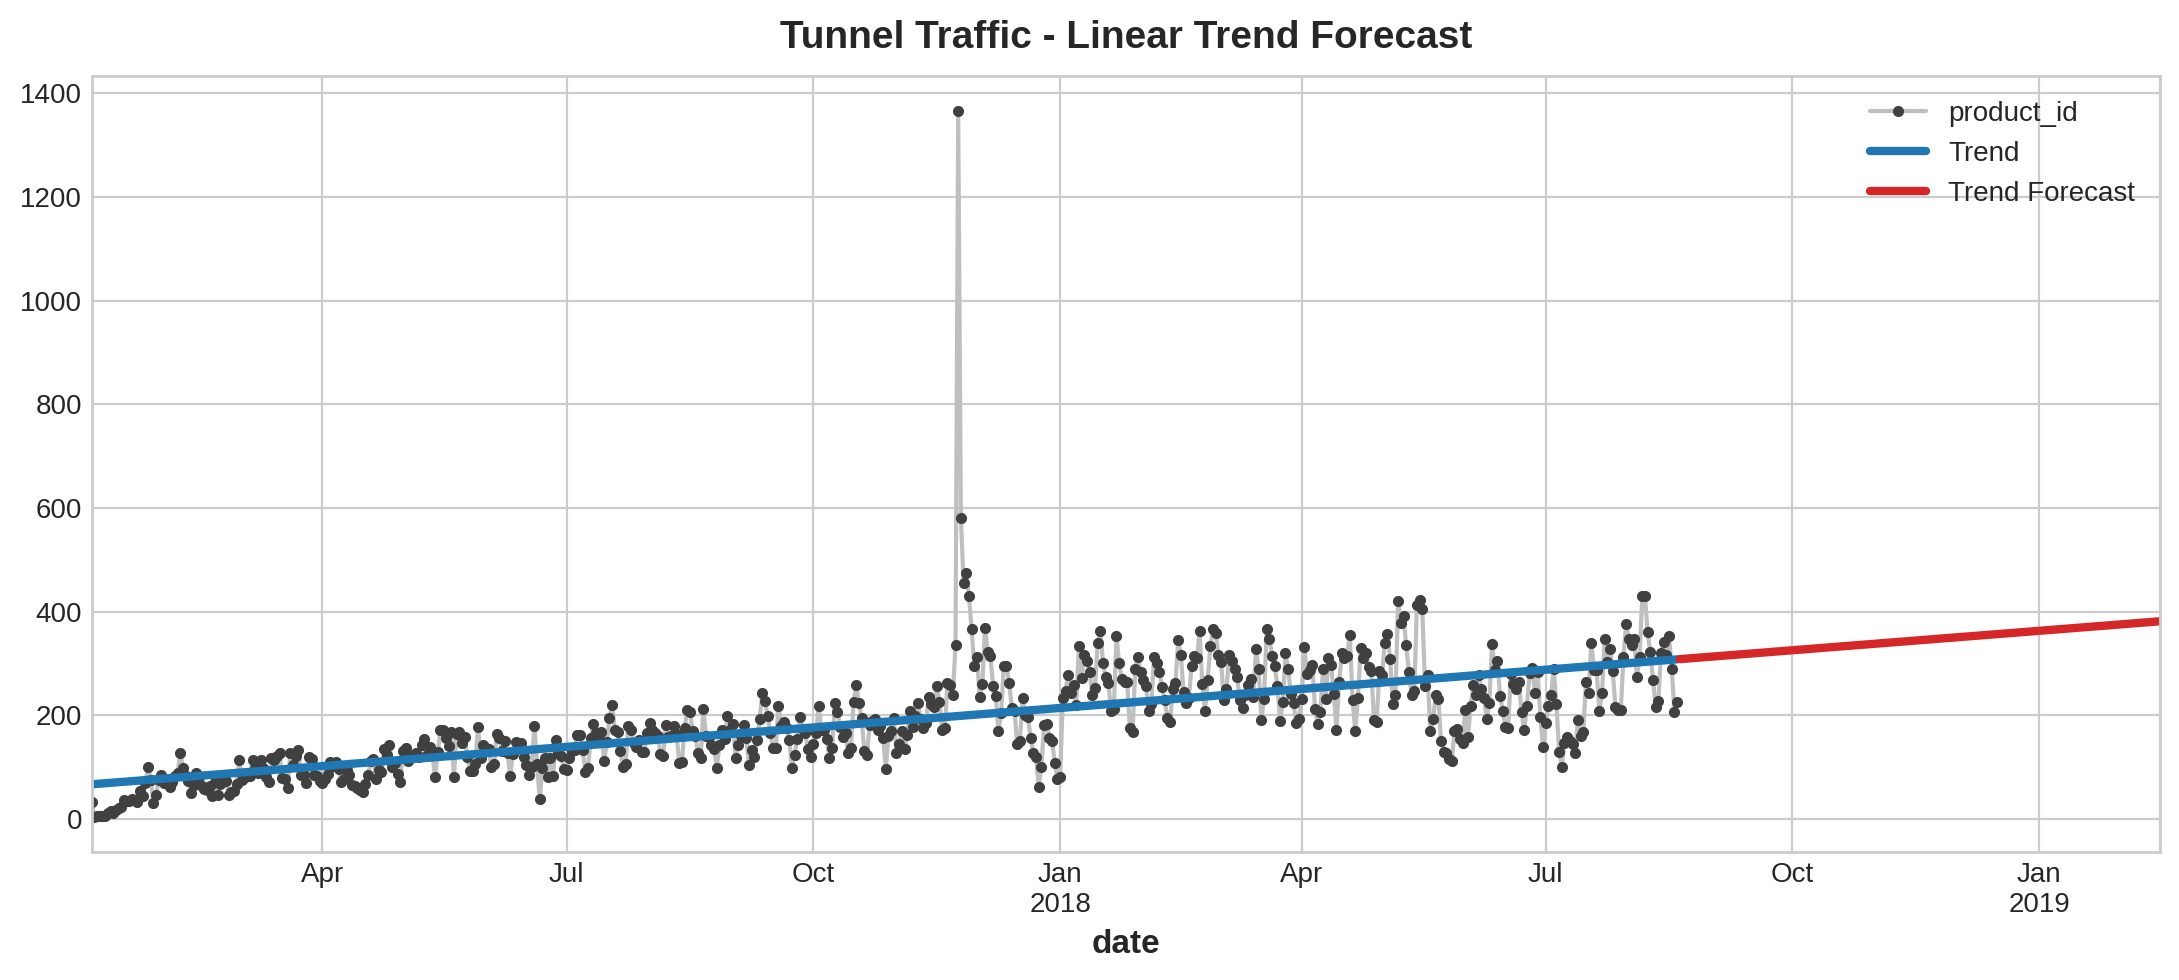

In [47]:
ax = avg_sales["2017-01-01":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2017-01-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

Seasonality

In [48]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = 1 / (365.25 / 1)  # Adjusted to represent one cycle per year in daily data
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=45,
        ha='right',
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    return ax

# Load the sales dataset
avg_sales = orders.groupby('date').agg({'product_id': 'count'}).reset_index()
avg_sales['date'] = pd.to_datetime(avg_sales['date'])
avg_sales = avg_sales.set_index('date').to_period("D")
avg_sales.head()


product_id
date                  
2017-01-05          32
2017-01-06           4
2017-01-07           5
2017-01-08           6
2017-01-09           6

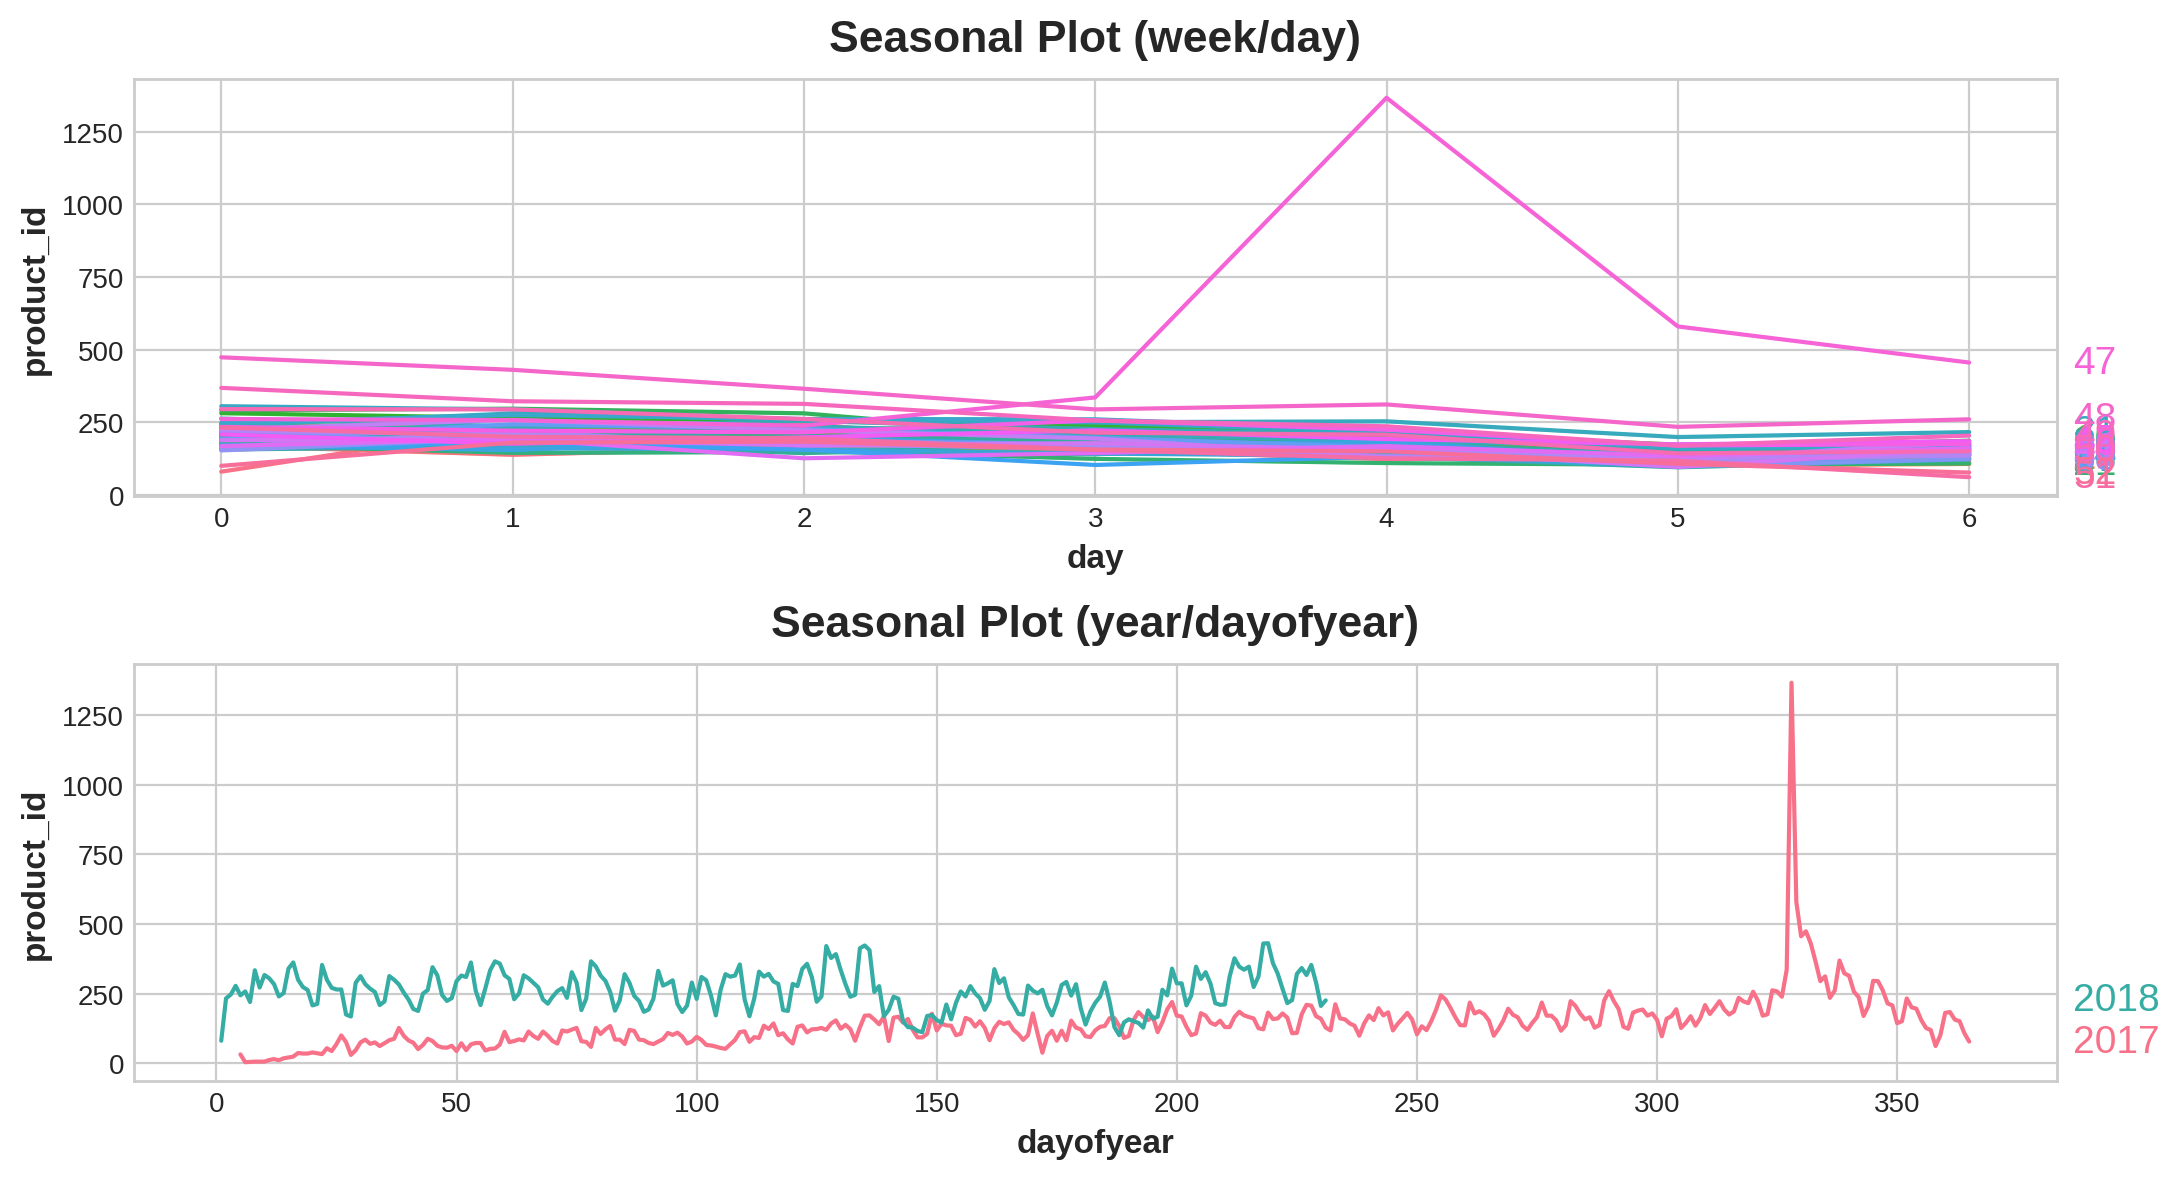

In [49]:
X = avg_sales.copy()

# days within a week
X['day'] = X.index.dayofweek # the x-axis (freq)
X['week'] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="product_id", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="product_id", period="year", freq="dayofyear", ax=ax1);

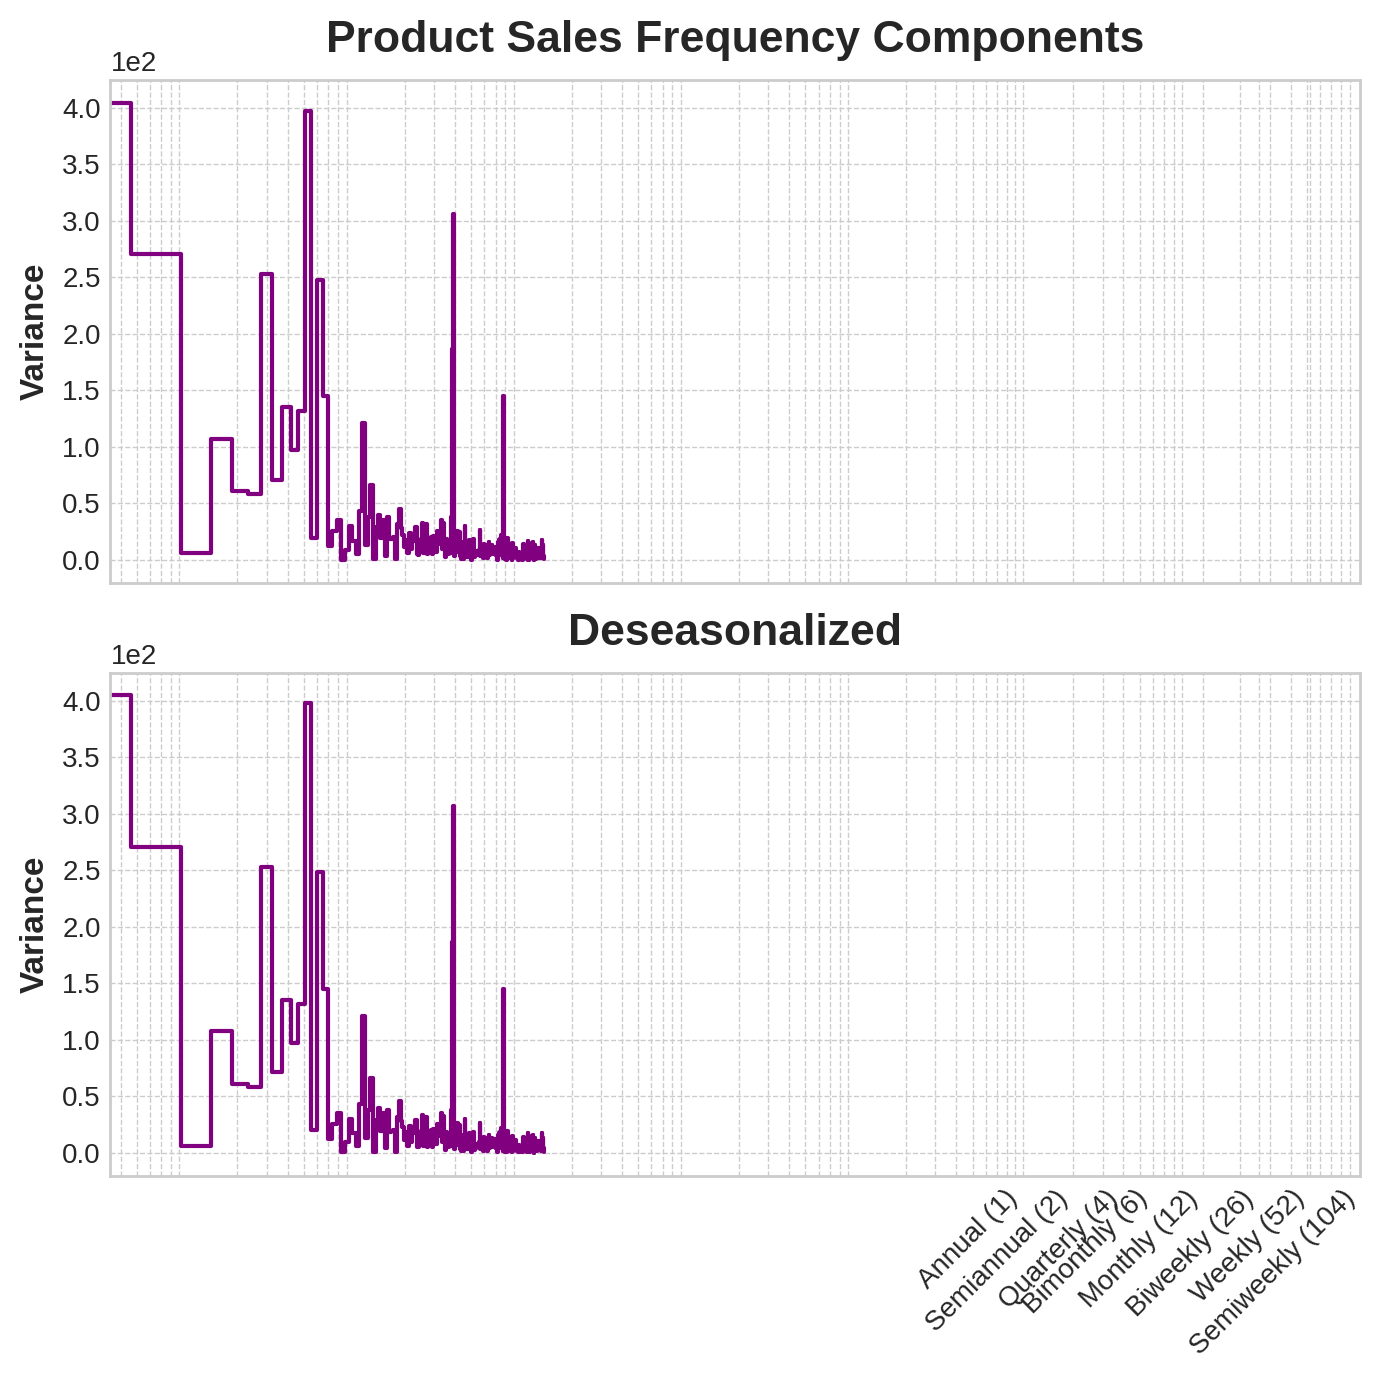

In [50]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(7, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [52]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=avg_sales.index,
    constant=True,   # dummy feature for bias (y-intercept)
    order=1,         # trend ( order 1 means linear)
    seasonal=True,   # weekly seasonality (indicators)
    additional_terms=[fourier], # annual seasonality
    drop=True,       # drop terms to avoid collinearity
)

X = dp.in_sample() # create features for dates in tunnel.index


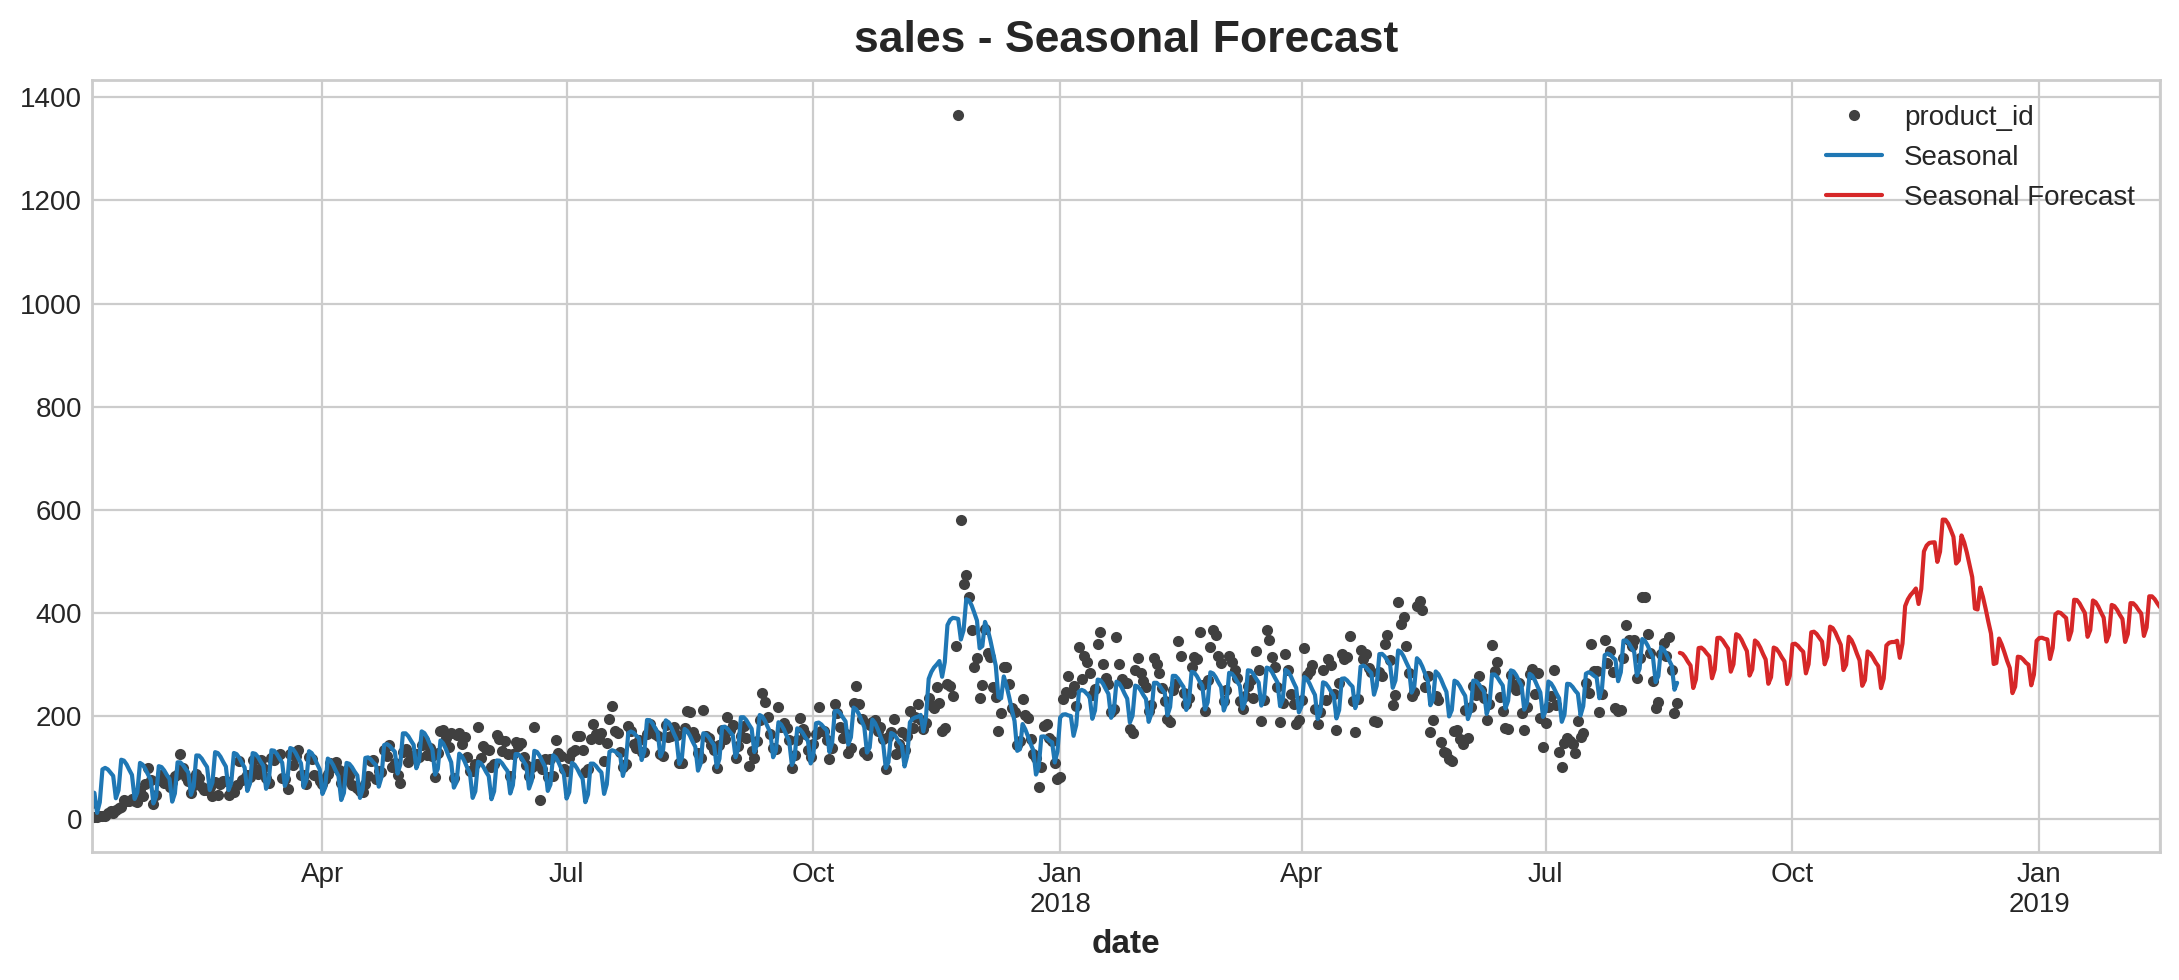

In [53]:
y = avg_sales['product_id']

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [54]:
sales= orders.copy()

In [55]:
sales['date'] = pd.to_datetime(sales['date'])

sales['date'] = sales['date'].dt.to_period('D')

# Set the 'product_category_name' and 'date' columns as index and sort the index
sales = sales.set_index(['product_name', 'date']).sort_index()

# Sample transformation for demonstration
sales = (
    orders
    .groupby(['product_name', 'date'])
    .size()
    .reset_index(name='demand')
)
#mag_sales = sales.loc(axis=1)[:, 'babe']
sales
sales['date'] = pd.to_datetime(sales['date'])
sales['date'] = sales['date'].dt.to_period('D')
sales.set_index('date', inplace=True)
sales

product_name  demand
date                                          
2017-01-05  agro_industry_and_commerce       0
2017-01-06  agro_industry_and_commerce       0
2017-01-07  agro_industry_and_commerce       0
2017-01-08  agro_industry_and_commerce       0
2017-01-09  agro_industry_and_commerce       0
...                                ...     ...
2018-08-15               watches_gifts      21
2018-08-16               watches_gifts      24
2018-08-17               watches_gifts       7
2018-08-18               watches_gifts      14
2018-08-19               watches_gifts       4

[43808 rows x 2 columns]

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

df = pd.DataFrame(sales)


# Ensure 'product_name' is categorical
df['product_name'] = df['product_name'].astype('category')
product_groups = df.groupby('product_name')['demand'].resample('D').sum().unstack('product_name').fillna(0)

# Create lag features
def create_features(df, lag=14):
    df = df.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['demand'].shift(i)
    df.dropna(inplace=True)
    return df

# Prepare the data
ml_data = df.reset_index()
ml_data = pd.get_dummies(ml_data, columns=['product_name'])
ml_data = ml_data.groupby('date').sum()  # Sum the demand for each product for simplicity
ml_data = create_features(ml_data)

# Split the data into train and test sets
X = ml_data.drop(['demand'], axis=1)
y = ml_data['demand']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Forecast for the next 14 days using Linear Regression
last_observation = X.iloc[-1:].copy()
forecasts_lr = []

for i in range(14):
    forecast = lr_model.predict(last_observation)[0]
    forecasts_lr.append(forecast)
    last_observation = last_observation.shift(-1, axis=1)
    last_observation.iloc[:, -1] = forecast

# Evaluate the Linear Regression model
actual_lr = y[-14:].values

# Compute evaluation metrics
def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    return mae, rmse, mape

mae_lr, rmse_lr, mape_lr = compute_metrics(actual_lr, forecasts_lr)
print(f"Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}, MAPE: {mape_lr}")



Linear Regression - MAE: 78.6068101613688, RMSE: 94.78852829142933, MAPE: 0.2672774241280134


In [57]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'sales' is your DataFrame
df = pd.DataFrame(sales)


# Ensure 'product_name' is categorical
df['product_name'] = df['product_name'].astype('category')

# Group data by 'product_name' and resample to daily frequency, filling missing values with 0
product_groups = df.groupby('product_name')['demand'].resample('D').sum().unstack('product_name').fillna(0)

# Create lag features using a sliding window approach
def create_features(df, lag=14):
    df = df.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['demand'].shift(i)
    df.dropna(inplace=True)
    return df

# Prepare the data
ml_data = df.reset_index()
ml_data = pd.get_dummies(ml_data, columns=['product_name'])
ml_data = ml_data.groupby('date').sum()  # Sum the demand for each product for simplicity
ml_data = create_features(ml_data)

# Split the data into train and test sets
X = ml_data.drop(['demand'], axis=1)
y = ml_data['demand']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Forecast for the next 14 days using Linear Regression
last_observation = X.iloc[-14:].copy()  # Use the last 14 days as the initial window
forecasts_lr = []

for i in range(14):
    forecast = lr_model.predict(last_observation.iloc[[i]])[0]
    forecasts_lr.append(forecast)
    # Shift the window and add the forecasted value
    if i + 1 < 14:
        last_observation.iloc[i + 1, -1] = forecast

# Align the forecast dates with the actual dates
forecast_dates = pd.date_range(start=ml_data.index[-1].to_timestamp(), periods=14)

# Evaluate the Linear Regression model
actual_lr = y[-14:].values

# Compute evaluation metrics
def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    return mae, rmse, mape

mae_lr, rmse_lr, mape_lr = compute_metrics(actual_lr, forecasts_lr)
print(f"Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}, MAPE: {mape_lr}")
# Align the forecast dates with the actual dates
forecast_dates = pd.date_range(start=ml_data.index[-1].to_timestamp() + pd.Timedelta(days=1), periods=14)


Linear Regression - MAE: 39.538060427221524, RMSE: 47.68913117315048, MAPE: 0.13262423315723773


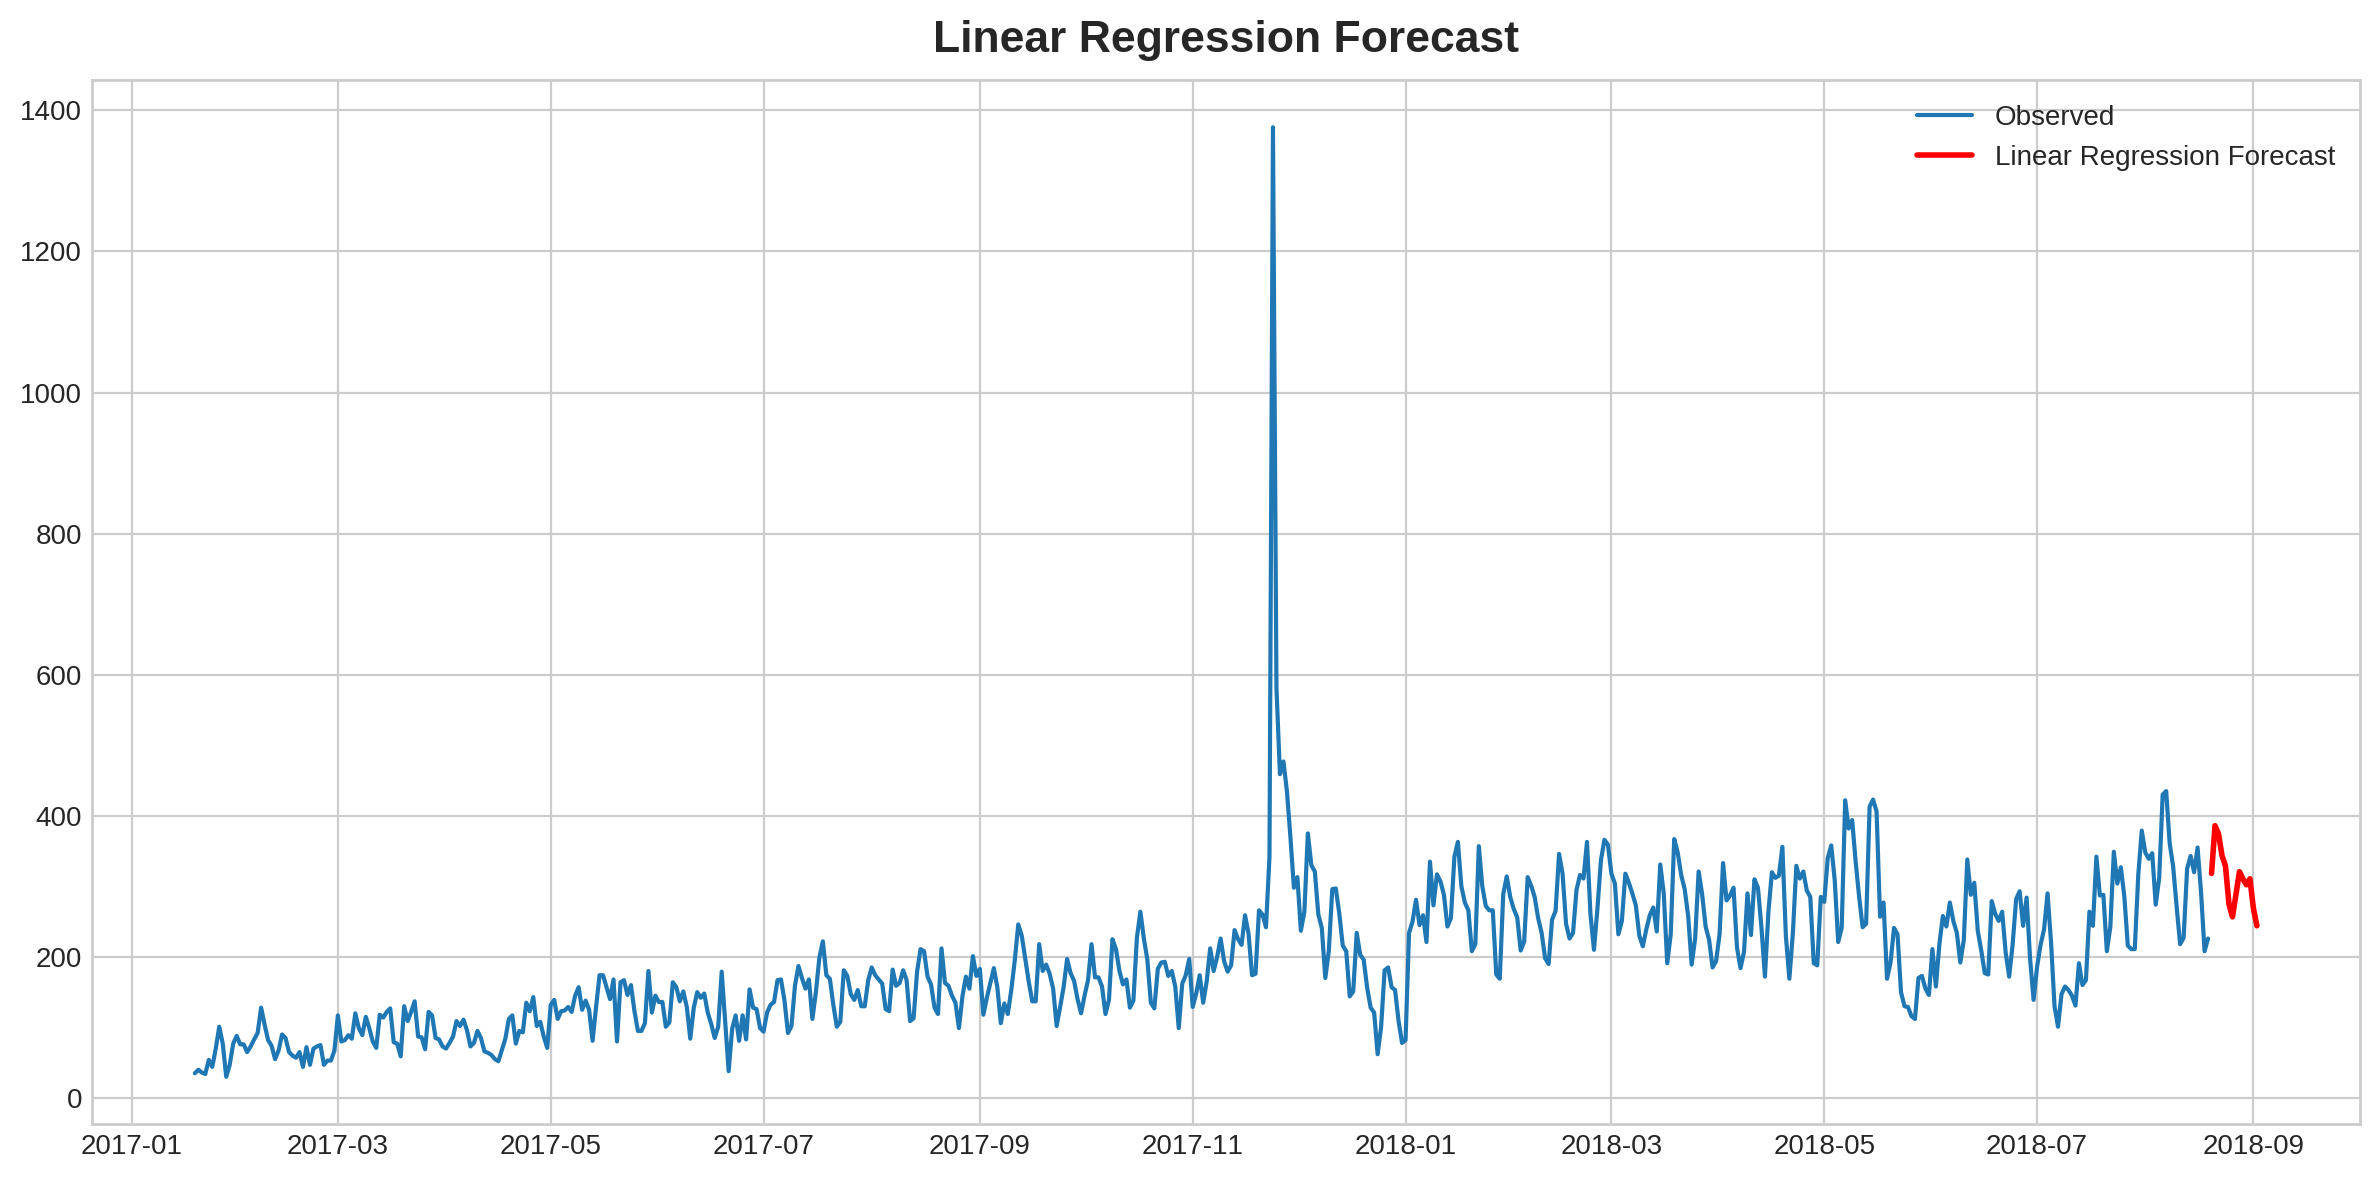

In [58]:
# Convert Period index to Timestamps
ml_data.index = ml_data.index.to_timestamp()

# Plot the results (simplified)
plt.figure(figsize=(12, 6))
plt.plot(ml_data.index, ml_data['demand'], label='Observed')
plt.plot(forecast_dates, forecasts_lr, label='Linear Regression Forecast', color='r', linewidth=2)
plt.title("Linear Regression Forecast")
plt.legend()
plt.show()


In [59]:
# Predicting Categories from Product Names
# Example: One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['product_name'])

# Example: Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['product_category'] = label_encoder.fit_transform(df['product_name'])

# i can then use these encoded columns as features for prediction

In [60]:
# Assuming df_encoded is the DataFrame with encoded categorical variables
# Assuming X_train and y_train are the features and target variable for training

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Replace 'category_column_name' with the correct column name for the category you want to predict
category_column_name = 'product_name_watches_gifts'
sample_category_features = df_encoded[df_encoded[category_column_name] == 1].copy()

# Ensure 'demand' column is present before dropping it
if 'demand' in sample_category_features.columns:
    # Create lag features for the sample_category_features DataFrame
    sample_category_features = create_features(sample_category_features)

    # Drop the 'demand' column
    sample_category_features.drop('demand', axis=1, inplace=True)

    # Predict for the individual category
    predicted_demand = lr_model.predict(sample_category_features)

    print("Predicted Demand for the Individual Category:", predicted_demand)
else:
    print("The 'demand' column is not present in the DataFrame.")

Predicted Demand for the Individual Category: [17.02992432 16.83884247 16.73292619 16.44704964 16.66773    16.86671496
 16.78946076 16.4955335  17.0619522  17.07177684 16.59675607 17.24203445
 16.71383854 17.71353382 17.91409426 18.40701909 18.362359   17.55209603
 17.52958823 17.62277134 18.77572359 17.85768584 17.40457496 18.31917378
 16.67909532 17.12354858 17.44685995 16.83525203 16.79299132 17.8787356
 17.0877366  16.4548997  17.54874608 17.22559613 16.73301797 18.10868257
 16.99162082 17.6261953  17.93412608 17.87405724 17.85208842 19.73982234
 18.10077354 18.38198831 18.64187968 19.59111774 17.5021702  18.9971887
 19.29897963 17.80715039 18.87943442 18.85407445 18.41594437 17.91883356
 20.83144512 17.70098455 19.90768675 23.46454169 18.77684441 19.60804925
 19.45067639 18.38353297 19.18635558 21.34965713 18.01793294 18.10043609
 18.87334198 17.49822068 19.65977332 19.38591028 18.49299126 17.3725998
 18.79579625 18.02309811 20.27249857 18.18649138 18.13269105 19.82068565
 18.5046

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function to fit SARIMA model and forecast
def fit_sarima(data, order, seasonal_order, steps):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=steps)
    return forecast.predicted_mean[-14:]  # Get the last 14 days of the forecast

# Parameters (these should be fine-tuned)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 7
steps = 21  # Forecast 21 days ahead (14 days starting 7 days from last date)

# Forecast for each product group
forecasts = {}


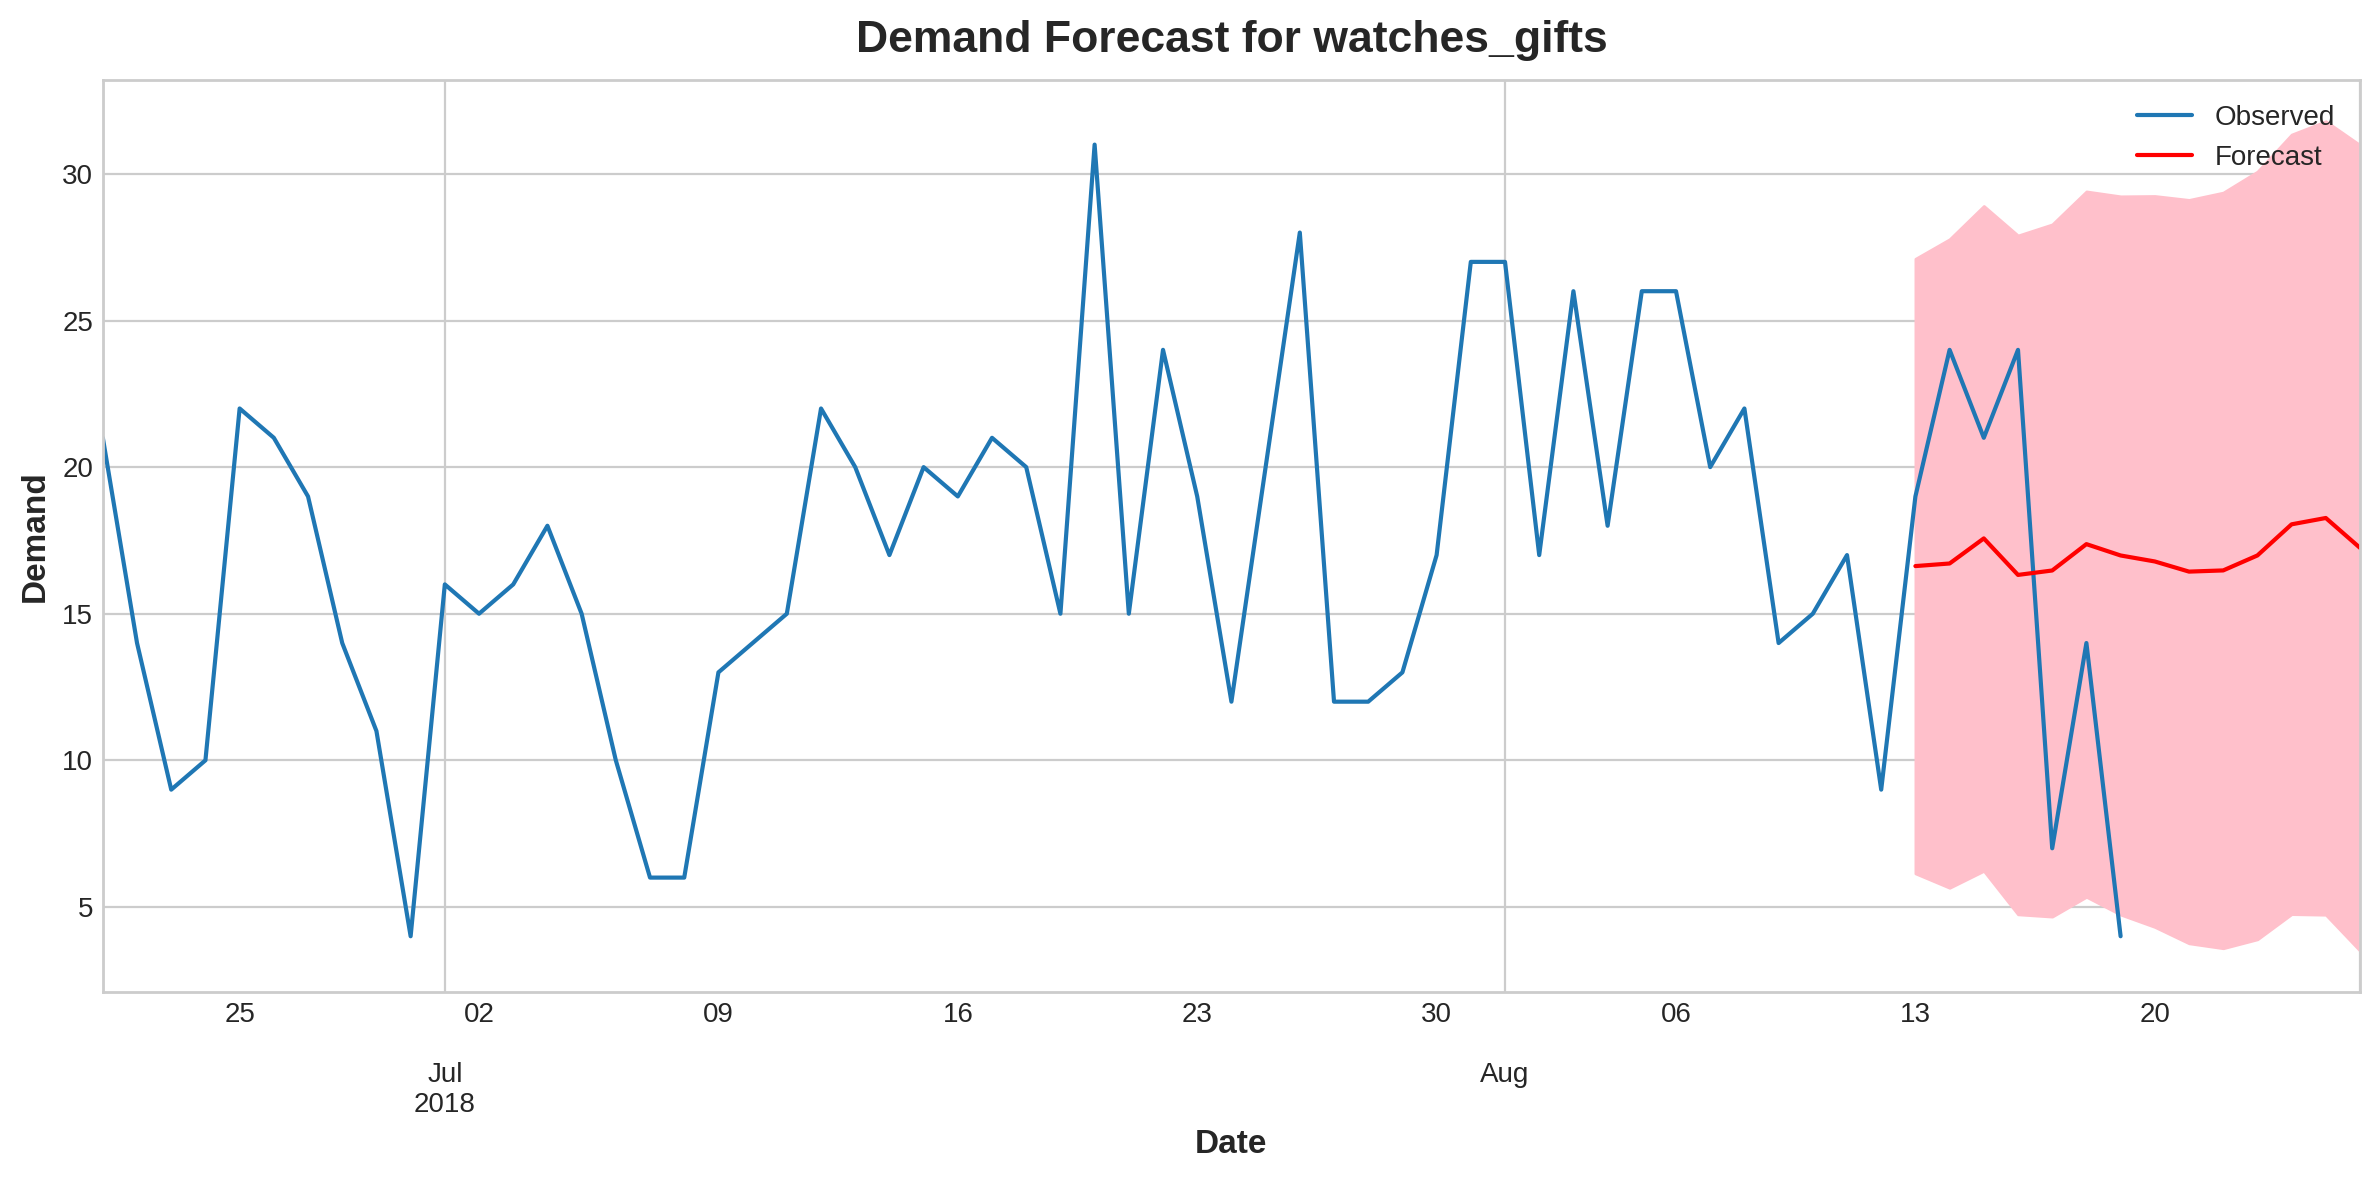

In [62]:
product_groups = df.groupby('product_name')['demand'].resample('D').sum().unstack('product_name').fillna(0)

def sarima_forecast(train, steps):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
    sarima_fit = model.fit(disp=False)
    forecast = sarima_fit.get_forecast(steps=steps)
    forecast_ci = forecast.conf_int()
    return forecast.predicted_mean, forecast_ci

# Forecast for each product group
forecast_period = 14
product_forecasts = {}

for product in product_groups.columns:
    train = product_groups[product].iloc[:-7]  # Training data up to 7 days before the last date
    predicted_mean, conf_int = sarima_forecast(train, forecast_period)
    product_forecasts[product] = (predicted_mean, conf_int)

# Plot the forecast for a sample product
sample_product = 'watches_gifts'
predicted_mean, conf_int = product_forecasts[sample_product]
fig, ax = plt.subplots(figsize=(12, 6))
product_groups[sample_product].iloc[-60:].plot(ax=ax, label='Observed')
predicted_mean.plot(ax=ax, label='Forecast', color='r')
ax.fill_between(predicted_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
ax.set_title(f'Demand Forecast for {sample_product}')
plt.legend()
plt.show()

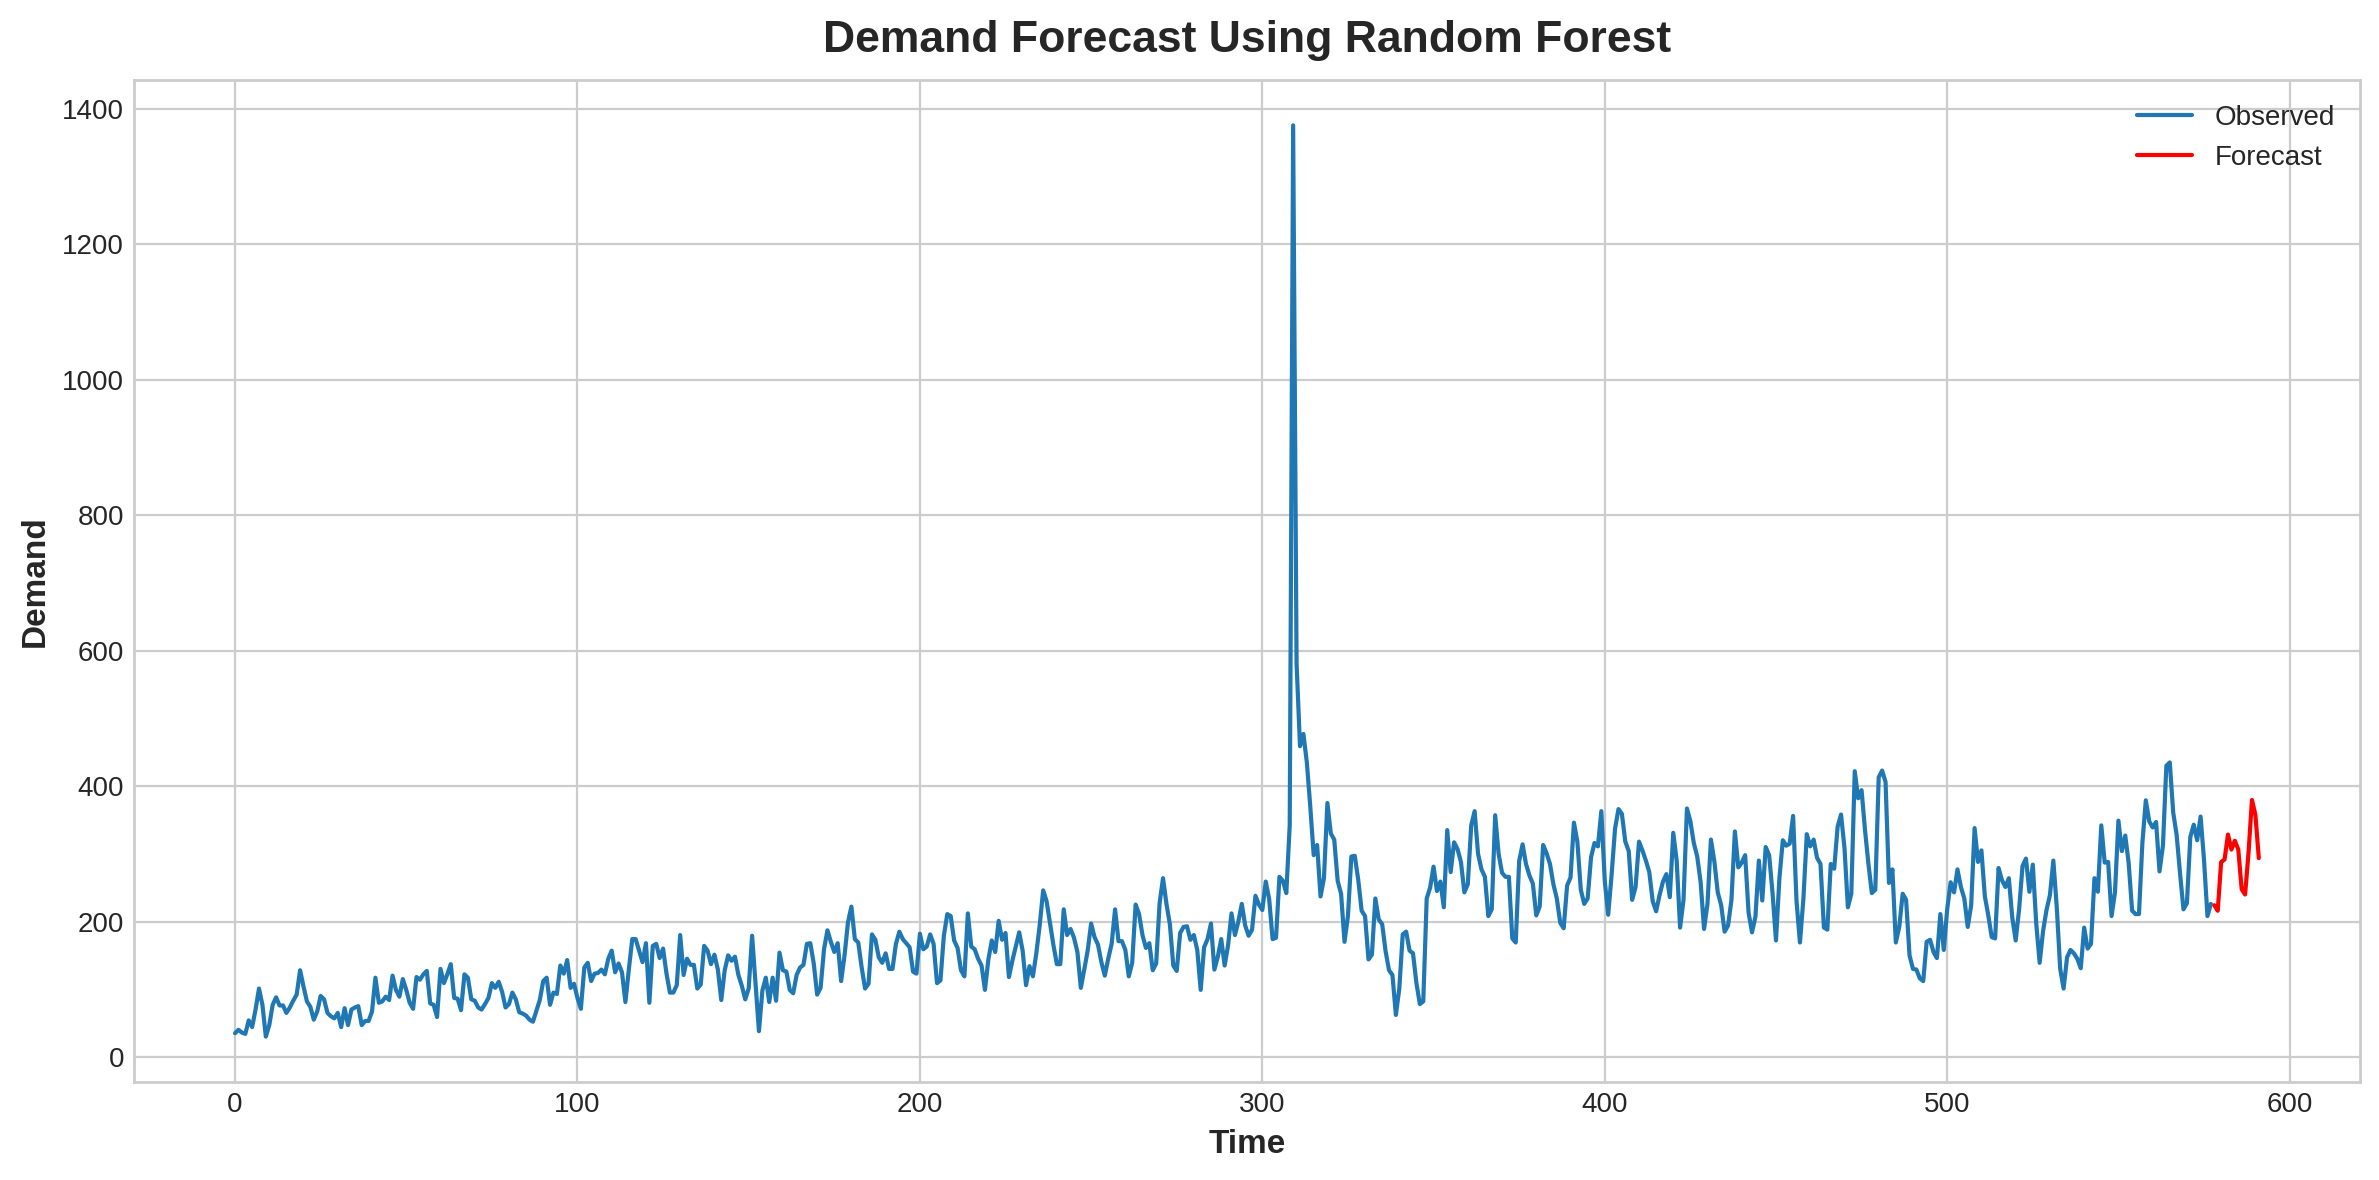

In [63]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'sales' is your DataFrame
df = pd.DataFrame(sales)

# Group data by 'product_name' and resample to daily frequency, filling missing values with 0
product_groups = df.groupby('product_name')['demand'].resample('D').sum().unstack('product_name').fillna(0)

# Create lag features
def create_features(df, lag=14):
    df = df.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['demand'].shift(i)
    df.dropna(inplace=True)
    return df

# Prepare the data
ml_data = df.reset_index()
ml_data = pd.get_dummies(ml_data, columns=['product_name'])
ml_data = ml_data.groupby('date').sum()  # Sum the demand for each product for simplicity
ml_data = create_features(ml_data)

# Split the data into train and test sets
X = ml_data.drop(['demand'], axis=1)
y = ml_data['demand']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Forecast for the next 14 days
last_observation = X.iloc[-1:].copy()
forecasts_rf = []

for i in range(14):
    forecast = rf_model.predict(last_observation)[0]
    forecasts_rf.append(forecast)
    last_observation = last_observation.shift(-1, axis=1)
    last_observation.iloc[:, -1] = forecast

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(range(len(y)), y, label='Observed')
plt.plot(range(len(y), len(y) + 14), forecasts_rf, label='Forecast', color='r')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Demand Forecast Using Random Forest')
plt.legend()
plt.show()


SARIMA - MAE: 1.0235888696786375, RMSE: 1.0741700983024096, MAPE: 4052095267160909.0
Random Forest - MAE: 94.67785714285712, RMSE: 110.24359006309618, MAPE: 0.3126601384497861


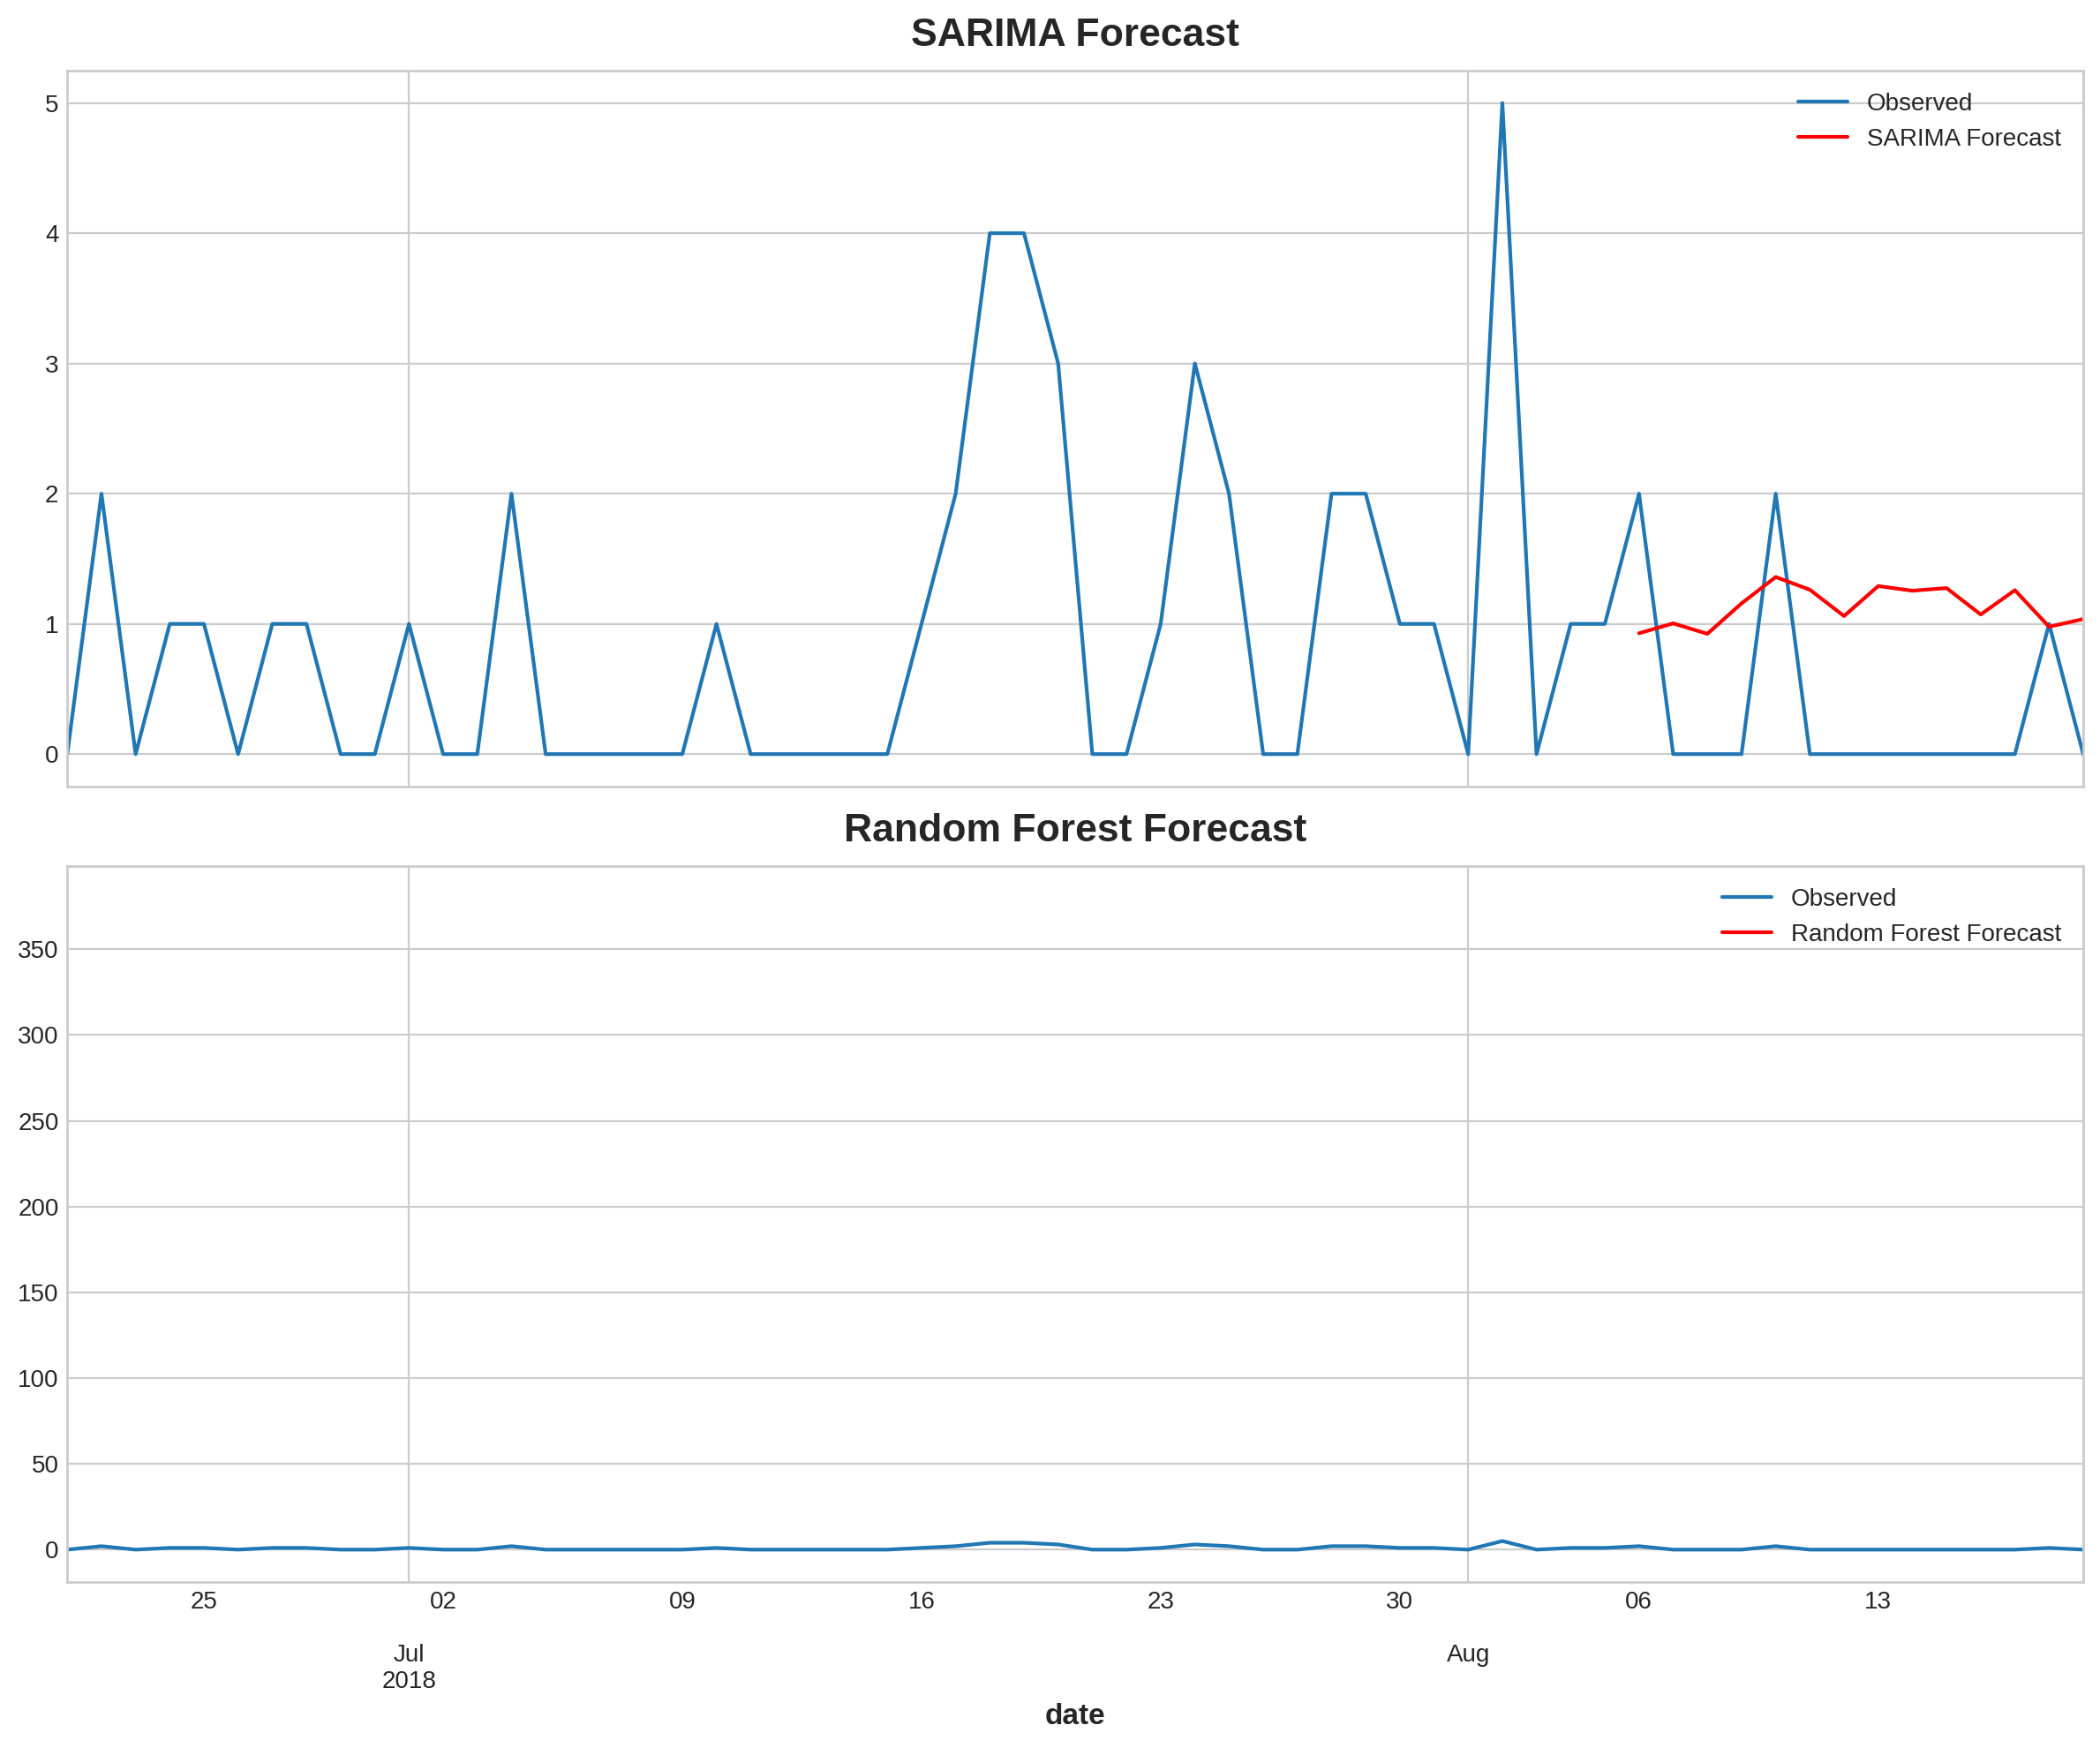

In [64]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Assuming 'sales' is your DataFrame
df = pd.DataFrame(sales)

# Ensure 'product_name' is categorical
df['product_name'] = df['product_name'].astype('category')

# Group data by 'product_name' and resample to daily frequency, filling missing values with 0
product_groups = df.groupby('product_name')['demand'].resample('D').sum().unstack('product_name').fillna(0)

# Create lag features
def create_features(df, lag=14):
    df = df.copy()
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['demand'].shift(i)
    df.dropna(inplace=True)
    return df

# Prepare the data
ml_data = df.reset_index()
ml_data = pd.get_dummies(ml_data, columns=['product_name'])
ml_data = ml_data.groupby('date').sum()  # Sum the demand for each product for simplicity
ml_data = create_features(ml_data)

# Split the data into train and test sets
X = ml_data.drop(['demand'], axis=1)
y = ml_data['demand']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Forecast for the next 14 days using Random Forest
last_observation = X.iloc[-1:].copy()
forecasts_rf = []

for i in range(14):
    forecast = rf_model.predict(last_observation)[0]
    forecasts_rf.append(forecast)
    last_observation = last_observation.shift(-1, axis=1)
    last_observation.iloc[:, -1] = forecast

# Function to evaluate SARIMA
def evaluate_sarima(df, product, forecast_period=14):
    train = df[product].iloc[:-forecast_period]  # Training data up to forecast period before the last date
    actual = df[product].iloc[-forecast_period:]  # Actual data for the forecast period
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
    sarima_fit = model.fit(disp=False)
    forecast = sarima_fit.get_forecast(steps=forecast_period)
    predicted_mean = forecast.predicted_mean
    return predicted_mean, actual

# Sample product for evaluation
sample_product = product_groups.columns[0]  # Choose the first product for demonstration

# Forecast for SARIMA
predicted_sarima, actual_sarima = evaluate_sarima(product_groups, sample_product)

# Evaluate Random Forest
actual_rf = y[-14:].values

# Compute evaluation metrics
def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted)
    return mae, rmse, mape

# SARIMA metrics
mae_sarima, rmse_sarima, mape_sarima = compute_metrics(actual_sarima, predicted_sarima)
print(f"SARIMA - MAE: {mae_sarima}, RMSE: {rmse_sarima}, MAPE: {mape_sarima}")

# Random Forest metrics
mae_rf, rmse_rf, mape_rf = compute_metrics(actual_rf, forecasts_rf)
print(f"Random Forest - MAE: {mae_rf}, RMSE: {rmse_rf}, MAPE: {mape_rf}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 10))
product_groups[sample_product].iloc[-60:].plot(ax=ax1, label='Observed')
predicted_sarima.plot(ax=ax1, label='SARIMA Forecast', color='r')
ax1.set_title("SARIMA Forecast")
ax1.legend()

product_groups[sample_product].iloc[-60:].plot(ax=ax2, label='Observed')
ax2.plot(range(len(product_groups[sample_product]) - 14, len(product_groups[sample_product])), forecasts_rf, label='Random Forest Forecast', color='r')
ax2.set_title("Random Forest Forecast")
ax2.legend()

plt.show()



Considering the metrics provided, the SARIMA model seems to have the lowest MAE and RMSE values, indicating that it has the smallest average prediction errors and the smallest spread of errors around the mean, respectively. However, the MAPE value for the SARIMA model is extremely high, which suggests that the percentage error is very large. This discrepancy may be due to extreme outliers in the data.

On the other hand, the Linear Regression model has the lowest MAPE value, indicating that it has the smallest percentage error on average. However, its MAE and RMSE values are higher than those of the SARIMA model, indicating larger absolute and squared errors.

The Random Forest model has the highest MAE and RMSE values, indicating larger prediction errors compared to the SARIMA and Linear Regression models. However, its MAPE value is relatively low compared to the SARIMA model.

In summary, if we prioritize absolute and squared errors, the SARIMA model might be preferred. However, if we prioritize percentage errors, the Linear Regression model might be preferred. It's essential to consider the specific requirements and characteristics of the problem domain when selecting the most suitable model. Additionally, further analysis and diagnostic checks should be performed to validate the chosen model's assumptions and evaluate its performance more comprehensively.


I would use Sarim's model but if the forecasting objective includes holidays and promotional days, I would recommend including more data about them in the model. because if demand forecasting is necessary to form a stock for sales during sales and holidays, the built model does not satisfy these conditions.
to improve the model performance you can use time series trimming, but ....

In [1]:
df.isnull().sum()
df.describe()


NameError: name 'df' is not defined

In [77]:
product = 'telephony'  # You can choose any product group
product_demand = product_groups[product]
product_demand_log = np.log1p(product_demand)

In [81]:
import statsmodels.api as sm

# Train-test split
train_size = int(len(product_demand_log) * 0.8)
train, test = product_demand_log[:train_size], product_demand_log[train_size:]

# Grid search to find the best SARIMA parameters
p = d = q = range(0, 3)  # Increased range
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = float("inf")
best_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except Exception as e:
            print(f"Exception for parameters {param}, {param_seasonal}: {e}")
            continue

if best_params is not None:
    print(f'Best SARIMA parameters: {best_params}')

    # Refit the model with the best parameters
    best_order, best_seasonal_order = best_params
    sarima_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_result = sarima_model.fit(disp=False)

    # Forecast for the next 14 days
    forecast_steps = 14
    forecast = sarima_result.get_forecast(steps=forecast_steps)
    forecast_values = np.expm1(forecast.predicted_mean)

    # Align the forecast dates with the actual dates
    forecast_dates = pd.date_range(start=train.index[-1].to_timestamp(), periods=forecast_steps + 1, inclusive='right')

    # Evaluate the SARIMA model
    actual_sarima = np.expm1(test[:forecast_steps].values)
    predicted_sarima = forecast_values.values

    def compute_metrics(actual, predicted):
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mape = mean_absolute_percentage_error(actual, predicted)
        return mae, rmse, mape

    mae_sarima, rmse_sarima, mape_sarima = compute_metrics(actual_sarima, predicted_sarima)
    print(f"SARIMA - MAE: {mae_sarima}, RMSE: {rmse_sarima}, MAPE: {mape_sarima}")

    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 6))
    train.plot(ax=ax, label='Train')
    test.plot(ax=ax, label='Test')
    ax.plot(forecast_dates[:-1], predicted_sarima, label='SARIMA Forecast', color='r')
    ax.set_title("SARIMA Forecast")
    ax.legend()

    plt.show()
else:
    print("No suitable SARIMA parameters found.")


KeyboardInterrupt: 

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except:
            continue

print(f'Best SARIMA parameters: {best_params}')

# Refit the model with the best parameters
best_order, best_seasonal_order = best_params
sarima_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)


Tips for Fine-Tuning:
Parameter Selection: Use grid search or automated methods like pmdarima's auto_arima to find the best parameters for each product group.
Model Validation: Use a train-test split to validate the model on unseen data and adjust parameters accordingly.
Handling Missing Data: Interpolate or fill missing values in the time series data.


<Axes: xlabel='date'>

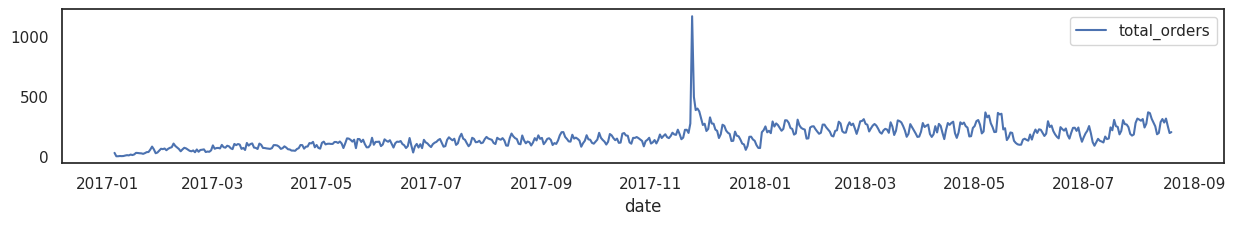

In [ ]:
daily_order = orders.groupby('date').agg(total_orders=('order_id', 'nunique'))
plt.figure(figsize=(15,2))
sns.lineplot(data=daily_order)

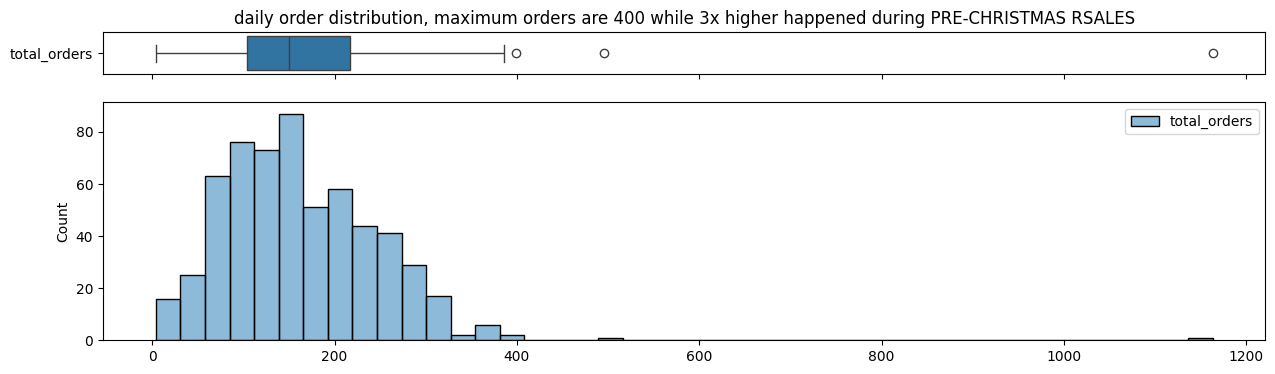

In [ ]:
# Let's take a look at the daily order distribution
# the maximum order in a day is around 400, while in PRE-CHRISTMAS RSALES it can get into 1.2k or 3 times higher.

fig, ax = plt.subplots(2,1,sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,4))
sns.boxplot(data=daily_order, orient="h", ax=ax[0])
sns.histplot(daily_order, ax=ax[1])
ax[0].set_title("daily order distribution, maximum orders are 400 while 3x higher happened during PRE-CHRISTMAS RSALES")
plt.show()

In [ ]:
trimming = winsorize(daily_order.values,(0.1,0.009))

# getting the trimmed data

daily_order['trimming'] = [trimming[idx][0] for idx in range(len(trimming))]

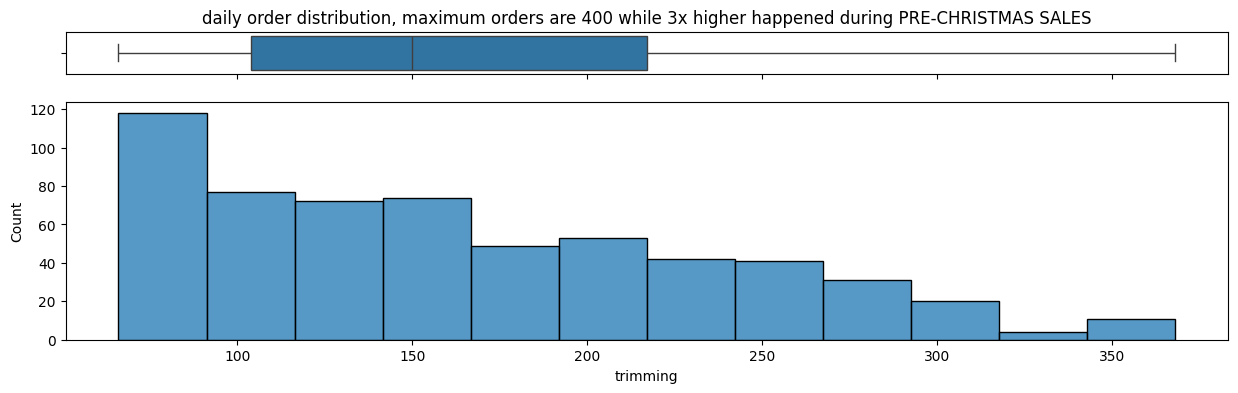

In [ ]:
fig, ax = plt.subplots(2,1,sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,4))
sns.boxplot(data=daily_order['trimming'], orient="h", ax=ax[0])
sns.histplot(daily_order['trimming'], ax=ax[1])
ax[0].set_title("daily order distribution, maximum orders are 400 while 3x higher happened during PRE-CHRISTMAS SALES")
plt.show()

In [ ]:
daily_order[daily_order['total_orders']!=daily_order['trimming']]

total_orders  trimming
date                              
2017-01-05            32        66
2017-01-06             4        66
2017-01-07             4        66
2017-01-08             6        66
2017-01-09             5        66
...                  ...       ...
2017-11-25           495       368
2017-11-26           386       368
2017-11-27           399       368
2017-11-28           375       368
2017-12-24            57        66

[63 rows x 2 columns]

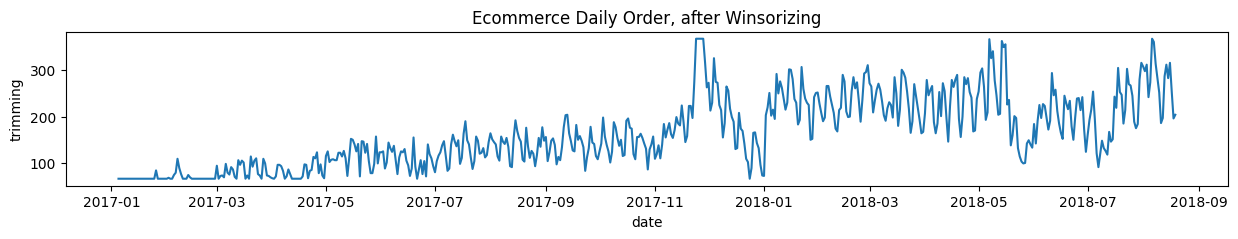

In [ ]:
# it looks much better!
plt.figure(figsize=(15,2))
sns.lineplot(data=daily_order['trimming'])
plt.title("Ecommerce Daily Order, after Winsorizing")
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_order['total_orders'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.698533
p-value: 0.074292
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569


Time series is Stationary if it has,

Constant Mean

Constant Variance

Constant Covariance

Let's verify it by observing change in mean, variance and statistical test (adfuller)

Overall, based on the ADF statistic and the p-value, we do not have enough evidence to conclude that the time series data is stationary


In [ ]:
orders.loc[orders['date']==pd.to_datetime('2017-11-24'), 'events'] = 'pre-cristmas'


In [ ]:
dates = df_outliers['date'].sort_values().unique()
num_dates = len(dates)
dates_train = dates[:int(0.8*num_dates)]
dates_test = dates[int(0.8*num_dates):]
train = df_outliers[df_outliers['date'].isin(dates_train)]
test = df_outliers[df_outliers['date'].isin(dates_test)]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train[['total_orders']])
train['scaling'] = scaler.transform(train[['total_orders']])
test['scaling'] = scaler.transform(test[['total_orders']])

In [ ]:
train['rmv_outliers'] = winsorize(train['scaling'], (0.01,0.009))

In [ ]:
winsorized_min, winsorized_max = train[train['rmv_outliers']!=train['scaling']]['rmv_outliers'].min(), train[train['rmv_outliers']!=train['scaling']]['rmv_outliers'].max()
winsorized_min, winsorized_max

(0.0017256255392579813, 0.3201035375323555)

In [ ]:
test.loc[test['scaling']>winsorized_max, 'rmv_outliers'] = winsorized_max
test.loc[test['scaling']<winsorized_min, 'rmv_outliers'] = winsorized_min
test.loc[(test['scaling']>=winsorized_min)&(test['scaling']<=winsorized_max), 'rmv_outliers'] = test[(test['scaling']>=winsorized_min)&(test['scaling']<=winsorized_max)]['scaling']